In [ ]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn')
import seaborn as sns

from sklearn import linear_model, metrics

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import time
import pickle
from pprint import pprint

# Read Dataset 2019

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/research/health/or/data_HLA/data/data_2019_scores.xlsx')
print("Dataframe with {} rows and {} columns.".format(df.shape[0], df.shape[1]))
df.head()

Dataframe with 20350 rows and 51 columns.


,Unnamed: 0,ID Inter,Especialidad,Fecha Informe,Intervención (Cod. OMC),Grupo OMC,Financiación,Entidad,Autorización,Quirófano,Hora planificación,Hora admisión,Entrada quirófano,Inicio intervención,Fin intervención,Salida quirófano,Tiempo (min.),Tipo,Urgente,AP,Cirujano,Anestesista,Ayudante,Instrumentista,Circulante,Auxiliar,delay_over_planned,time_to_or,idle_or_begin,surgery_time,idle_or_end,or_time,leader,team,team_size,partner_exposure,surgeon_experience,shift,dow,avg_OMC,avg_surgeon,gender_Cirujano,gender_Anestesista,gender_Ayudante,gender_Instrumentista,gender_Circulante,gender_Auxiliar,nr_females,cirujano_ayudante_familiarity,same_gender,gender_diversity
0,4783,786168,TRATAMIENTO DEL DOLOR,2019-01-02 10:01:00,"RADIOFRECUENCIA DE CADENA SIMPATICA CERVICAL, ...",Grupo VI,Aseguradoras Privadas-ASISA,ASISA,13986806708,Quirofano 3,2019-01-02 08:30:00,2019-01-02 08:56:00,2019-01-02 09:48:00,2019-01-02 09:49:00,2019-01-02 10:00:00,2019-01-02 10:01:00,13.0,AMBULANTE,NO,NO,"reig ruigomez, enrique",NaN,NaN,NaN,fernandez garcia susana,NaN,79.0,52.0,1,11,1,13,0.000000,0.000000,2,0.308160,957,M,W,21.306165,21.269190,m,NaN,NaN,NaN,w,NaN,1,0,0,0.500000
1,7906,785246,CIRUGÍA PLÁSTICA Y REPARADORA,2019-01-02 11:11:00,PEXIA MAMARIA (CON O SIN PROTESIS),Otros Actos Quirurgicos,Otras entidades,CLINICA FORCADA,REQUIERE,Quirofano 9,2019-01-02 08:30:00,2019-01-02 08:37:00,2019-01-02 09:51:00,2019-01-02 09:52:00,2019-01-02 11:09:00,2019-01-02 11:16:00,85.0,CCI,NO,NO,"forcada melero, eduardo","casanova barea, javier",NaN,NaN,francino navarro maria,bascon berral carmen,82.0,74.0,1,77,7,85,0.070588,43.500000,4,0.067136,286,M,W,494.483112,180.096774,m,m,NaN,NaN,w,w,2,0,0,0.500000
2,15297,785938,CIRUGÍA PLÁSTICA Y REPARADORA,2019-01-02 12:11:00,PEXIA MAMARIA (CON O SIN PROTESIS),Otros Actos Quirurgicos,Otras entidades,"DE FRUTOS ESPINAR, M.PILAR",NO REQUIERE,Quirofano 10,2019-01-02 08:30:00,2019-01-02 08:37:00,2019-01-02 08:55:00,2019-01-02 08:56:00,2019-01-02 12:07:00,2019-01-02 12:10:00,195.0,CCI,NO,NO,"de frutos espinar, maria del pilar","yumar morales, m del carmen",NaN,NaN,hernandez rosa melisa,NaN,26.0,18.0,1,191,3,195,0.029260,11.333333,3,0.042228,81,M,W,494.483112,177.164557,w,w,NaN,NaN,w,NaN,3,0,0,0.000000
3,15444,785089,CIRUGÍA PLÁSTICA Y REPARADORA,2019-01-02 14:15:00,LIPOSUCCION,Otros Actos Quirurgicos,Otras entidades,BEAUTIFUL BEAUTY,REQUIERE,Quirofano 2,2019-01-02 08:30:00,2019-01-02 07:57:00,2019-01-02 09:24:00,2019-01-02 09:25:00,2019-01-02 14:11:00,2019-01-02 14:12:00,288.0,CCI,NO,NO,"palazon cabanes, javier","perez sancho, juan carlos",NaN,NaN,NaN,NaN,55.0,87.0,1,286,1,288,0.013514,1.000000,2,0.033532,2,M,W,162.648501,124.500000,m,m,NaN,NaN,NaN,NaN,0,0,0,0.000000
4,17773,785250,CIRUGÍA PLÁSTICA Y REPARADORA,2019-01-02 10:44:00,CLITORIPLASTIA,Grupo IV,Otras entidades,"BONASTRE JULIA, JORGE",REQUIERE,Quirofano 3,2019-01-02 08:30:00,2019-01-02 08:57:00,2019-01-02 09:29:00,2019-01-02 09:30:00,2019-01-02 10:40:00,2019-01-02 10:41:00,72.0,AMBULANTE,NO,NO,"bonastre juliá, jorge","sante serna, luis",NaN,NaN,NaN,villa rodriguez mª paz,60.0,32.0,1,70,1,72,0.046667,15.000000,3,0.026821,0,M,W,NaN,NaN,m,m,NaN,NaN,NaN,w,1,0,0,0.444444


# Read Historical Data 2016-18

In [ ]:
year = 2016
namefile = '/content/drive/My Drive/research/health/or/data_HLA/data/datos_' + str(year) + '.xlsx'
df_historic = pd.read_excel(namefile, header=0)
print(f"** Dataset Year {year} Size :: Nr. Rows = {df_historic.shape[0]}; Nr. Columns = {df_historic.shape[1]}")

for year in [2017, 2018]:
  namefile = '/content/drive/My Drive/research/health/or/data_HLA/data/datos_' + str(year) + '.xlsx'
  aux = pd.read_excel(namefile, header=0)
  print(f"** Dataset Year {year} Size :: Nr. Rows = {aux.shape[0]}; Nr. Columns = {aux.shape[1]}")
  df_historic = pd.concat([df_historic, aux])

print(f"** Dataset with historical data Size :: Nr. Rows = {df_historic.shape[0]}; Nr. Columns = {df_historic.shape[1]}")



# transform names in lower case
fields = ['Cirujano', 'Anestesista', 'Ayudante', 'Instrumentista', 'Circulante', 'Auxiliar']
for col in fields:
  df_historic[col] = df_historic[col].replace(np.nan, '')
  df_historic[col] = df_historic[col].str.lower()

df_historic.tail()

** Dataset Year 2016 Size :: Nr. Rows = 19410; Nr. Columns = 25
** Dataset Year 2017 Size :: Nr. Rows = 18245; Nr. Columns = 25
** Dataset Year 2018 Size :: Nr. Rows = 19477; Nr. Columns = 25
** Dataset with historical data Size :: Nr. Rows = 57132; Nr. Columns = 25


,ID Inter,Especialidad,Fecha Informe,Intervención (Cod. OMC),Grupo OMC,Financiación,Entidad,Autorización,Quirófano,Hora planificación,Hora admisión,Entrada quirófano,Inicio intervención,Fin intervención,Salida quirófano,Tiempo (min.),Tipo,Urgente,AP,Cirujano,Anestesista,Ayudante,Instrumentista,Circulante,Auxiliar
19472,609532,TRAUMATOLOGÍA Y CIRUGÍA ORTOPÉDICA,2018-01-02 12:16:00,FRACTURA FEMUR PER-SUB Y TROCANTEREA. TRATAMIE...,Grupo V,Aseguradoras Privadas-ASISA,ASISA,REQUIERE,Quirofano 4,2018-01-02 08:30:00,2018-01-02 09:29:00,2018-01-02 10:09:00,2018-01-02 10:10:00,2018-01-02 10:40:00,2018-01-02 10:41:00,32.0,CCI,NO,NO,"galindo andujar, enrique","garrido reche, elena","martinez trives, joaquin",de la cruz manzanero baldomero,,torres navarro marta
19473,617029,CIRUGÍA PLÁSTICA Y REPARADORA,2018-01-22 10:22:00,PROTESIS DE MAMA,Otros Actos Quirurgicos,Otras entidades,LECLINICS MEDIC.EST. Y CIR.PL.,REQUIERE,Quirofano 3,2018-01-22 09:00:00,2018-01-22 07:29:00,2018-01-22 08:55:00,2018-01-22 09:15:00,2018-01-22 10:10:00,2018-01-22 10:15:00,80.0,AMBULANTE,NO,NO,"de frutos espinar, maria del pilar","infante flores, elizabeth",,,,barajas reyes montserrat
19474,615644,DIGESTIVO,2018-01-18 17:32:00,COL/RET BALON GASTRICO,Grupo 0,Otras entidades,BEAUTIFUL BEAUTY,REQUIERE,Quirofano 1,2018-01-18 15:45:00,2018-01-18 14:47:00,2018-01-18 17:19:00,2018-01-18 17:19:00,2018-01-18 17:24:00,2018-01-18 17:35:00,16.0,AMBULANTE,NO,NO,"loscos valerio, jose maria","tranche alvarez-cagigas, itziar leire",,,perez albeniz moras mª del mar,
19475,621998,TRAUMATOLOGÍA Y CIRUGÍA ORTOPÉDICA,2018-02-05 20:29:00,"SINOVECTOMIAS (CADERA, RODILLA). TRATAMIENTO Q...",Grupo VI,Aseguradoras Privadas-ASISA,ASISA,REQUIERE,Quirofano 4,2018-02-05 15:30:00,2018-02-05 19:34:00,2018-02-05 19:51:00,2018-02-05 19:52:00,2018-02-05 21:26:00,2018-02-05 20:19:00,28.0,CCI,NO,NO,"fernandez fernandz-arroyo, jose manuel","perez sancho, juan carlos",,,esperanza barrios david,
19476,613445,CIRUGÍA MAXILOFACIAL,2018-01-11 17:57:00,EXTRACCIÓN DE TRES CORDALES INCLUIDOS,Grupo II,Aseguradoras Privadas-ASISA,ASISA,12433602704,Quirofano 11,2018-01-11 17:00:00,2018-01-11 13:47:00,2018-01-11 16:25:00,2018-01-11 16:35:00,2018-01-11 17:54:00,2018-01-11 18:11:00,106.0,AMBULANTE,NO,NO,"navarro cuellar, ignacio javier","de la calle reviriego, jose luis",,,hernandez rosa melisa,huertas gonzalez rosario


# Computation new Familiarity

In [ ]:
%%time
from collections import defaultdict
fields = ['Cirujano', 'Anestesista', 'Ayudante', 'Instrumentista', 'Circulante', 'Auxiliar']
dg = defaultdict(defaultdict)
#historic = df_historic.head(10)
historic = df_historic
for col in fields:
  historic[col] = historic[col].replace(np.nan, '')
  historic[col] = historic[col].str.lower()
lists = historic[fields].values.tolist()
for k, team in enumerate(lists):
  if k % 1000 == 0:
    print("[{}/{}] Team = {}.".format(k, len(lists), team))
  #print("*"*80)
  for i in range(len(team)):
    if team[i] == '':
      continue
    for j in range(len(team)):
      if team[j] == '' or i == j:
        continue
      #print("Looking for '{}' and '{}'".format(team[i], team[j]))
      if team[j] in dg[team[i]]:
        dg[team[i]][team[j]] += 1
      else:
        dg[team[i]][team[j]] =1
    #print(dg[team[i]])

#json.dumps(dg)
print("Dictionary has {} keys.".format(len(dg.keys())))

[0/57132] Team = ['vazquez pelillo, juan carlos', 'perez sancho, juan carlos', '', '', 'de frutos llorente marta', 'gutierrez pinto sonia'].
[1000/57132] Team = ['loscos valerio, jose maria', 'garcia beracierto, liete yainer', '', '', '', 'frates huerta gema'].
[2000/57132] Team = ['arbizu duralde, álvaro', 'muñoz muñoz, juan francisco', '', '', '', 'gutierrez pinto sonia'].
[3000/57132] Team = ['rodriguez soria, virna', 'montes granero, mª jose', 'silvente san nicasio, catiana', '', 'esperanza barrios david', ''].
[4000/57132] Team = ['morbelli ., hector mario', 'tranche alvarez-cagigas, itziar leire', '', '', '', 'sanchez felix isabel elena'].
[5000/57132] Team = ['utrera busquets, marta', 'gomez ribot, juan maria', 'rodriguez soria, virna', '', '', 'lopez anton elena'].
[6000/57132] Team = ['mendoza hernandez, juan luis', 'camara zarraga, koldo', '', '', '', 'torres navarro marta'].
[7000/57132] Team = ['loscos valerio, jose maria', 'pastor jimeno, salvador alvaro', '', '', '', 'san

Description Exposure Values :: 
Mean 	= 0.155
Median 	= 0.104
StDev 	= 0.152


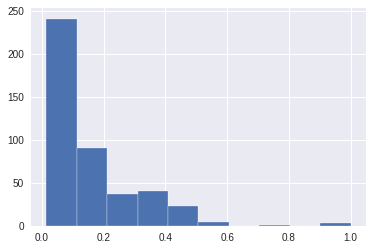

In [ ]:
# partner exposure for each member in the dictionary
#exposure = defaultdict(defaultdict)
exposure = {}
for key in dg.keys():
  experience = sum(dg[key].values())
  exposure_score = sum([(nr/experience)**2 for nr in dg[key].values()])
  exposure[key] = exposure_score
print("Description Exposure Values :: ")
myList = list(exposure.values())
print("Mean \t= {:.3f}".format(np.mean(myList)))
print("Median \t= {:.3f}".format(np.median(myList)))
print("StDev \t= {:.3f}".format(np.std(myList)))
plt.hist(exposure.values(), edgecolor='white');

In [ ]:
%%time
myList = df  # list for which we want to compute scores
#print("** DICTIONARY **")
#print(json.dumps(dg))
for col in fields:
  myList[col] = myList[col].replace(np.nan, '')
  myList[col] = myList[col].str.lower()

leader_familiarity = []
team_familiarity = []
partner_exposure = []
size = []
print("Computing scores for {} surgery teams.".format(len(myList)))
for counter,idx in enumerate(myList.index):
  
  team = myList.loc[idx][fields].values
  #print("Team ", team)
  team_score = 0.0
  leader_score = 0.0
  team_size = 0
  partner_exposure_score = 0.0
  for i in range(len(team)):
    if team[i] == '':
      continue
    team_size += 1
    #print("** Looking for member {}:: ".format(team[i]))
    if team[i] in exposure.keys():
      partner_exposure_score += exposure[team[i]]
      #print("\t with exposure {:.3f}".format(exposure[team[i]]))
    for j in range(len(team)):
      if team[j] == '' or i == j:
        continue
      if team[j] in dg[team[i]]:
        if i == 0: # cirujano
          leader_score += dg[team[i]][team[j]]
        team_score += dg[team[i]][team[j]]
        #print("\t with member {} \t {}".format(team[j], dg[team[i]][team[j]]))
        
    
    #input("aka")
  
  if team_size > 1:
    leader_score /= (team_size-1)
    team_score /= team_size*(team_size-1)
    partner_exposure_score /= team_size

  if idx % 1000 == 0:
    print("\t Team # {:5d} [idx = {:5d}, size = {}] Team score = {:.3f}\t Leader score = {:.3f} \t Partner Exposure score = {:.3f}".format(counter, idx, team_size, team_score, leader_score, partner_exposure_score))
  leader_familiarity.append(leader_score)
  team_familiarity.append(team_score)
  size.append(team_size)
  partner_exposure.append(partner_exposure_score)

df['new_leader'] = leader_familiarity
df['new_team'] = team_familiarity
df['new_partner_exposure'] = partner_exposure
df['new_team_size'] = size
df.to_excel('/content/drive/My Drive/research/health/or/data_HLA/data/data_2019_scores_v2.xlsx', index=False)
df.head()

Computing scores for 20350 surgery teams.
	 Team #     0 [idx =     0, size = 2] Team score = 0.000	 Leader score = 0.000 	 Partner Exposure score = 0.308
	 Team #  1000 [idx =  1000, size = 3] Team score = 118.667	 Leader score = 177.000 	 Partner Exposure score = 0.045
	 Team #  2000 [idx =  2000, size = 4] Team score = 33.667	 Leader score = 46.333 	 Partner Exposure score = 0.035
	 Team #  3000 [idx =  3000, size = 5] Team score = 55.800	 Leader score = 24.000 	 Partner Exposure score = 0.022
	 Team #  4000 [idx =  4000, size = 4] Team score = 83.500	 Leader score = 141.667 	 Partner Exposure score = 0.066
	 Team #  5000 [idx =  5000, size = 4] Team score = 75.333	 Leader score = 117.667 	 Partner Exposure score = 0.039
	 Team #  6000 [idx =  6000, size = 3] Team score = 3.000	 Leader score = 2.500 	 Partner Exposure score = 0.048
	 Team #  7000 [idx =  7000, size = 3] Team score = 114.000	 Leader score = 171.000 	 Partner Exposure score = 0.036
	 Team #  8000 [idx =  8000, size = 

In [ ]:
np.round(df[['new_partner_exposure', 'new_leader', 'new_team', 'new_team_size', 'surgeon_experience', 'nr_females', 'cirujano_ayudante_familiarity', 'gender_diversity']].agg(['mean','std']),2)

,new_partner_exposure,new_leader,new_team,new_team_size,surgeon_experience,nr_females,cirujano_ayudante_familiarity,gender_diversity
mean,0.09,223.02,210.28,3.21,403.08,1.62,10.78,0.36
std,0.10,417.37,398.55,0.85,637.86,0.97,50.28,0.19


In [ ]:
np.round(df[['new_partner_exposure', 'new_leader', 'new_team', 'new_team_size', 'surgeon_experience', 'nr_females', 'cirujano_ayudante_familiarity', 'gender_diversity']].corr(),2)

,new_partner_exposure,new_leader,new_team,new_team_size,surgeon_experience,nr_females,cirujano_ayudante_familiarity,gender_diversity
new_partner_exposure,1.00,0.61,0.62,-0.48,0.15,-0.19,-0.12,-0.08
new_leader,0.61,1.00,0.99,-0.29,0.45,-0.13,-0.06,0.05
new_team,0.62,0.99,1.00,-0.29,0.39,-0.13,-0.06,0.05
new_team_size,-0.48,-0.29,-0.29,1.00,-0.23,0.57,0.31,0.30
surgeon_experience,0.15,0.45,0.39,-0.23,1.00,-0.15,-0.12,-0.06
nr_females,-0.19,-0.13,-0.13,0.57,-0.15,1.00,0.09,0.16
cirujano_ayudante_familiarity,-0.12,-0.06,-0.06,0.31,-0.12,0.09,1.00,0.09
gender_diversity,-0.08,0.05,0.05,0.30,-0.06,0.16,0.09,1.00


## Average Times

In [ ]:
df = pd.read_excel('/content/drive/My Drive/research/health/or/data_HLA/data/data_2019_scores_v2.xlsx')
df.shape


(20350, 55)

In [ ]:
df_historic.head()

,ID Inter,Especialidad,Fecha Informe,Intervención (Cod. OMC),Grupo OMC,Financiación,Entidad,Autorización,Quirófano,Hora planificación,Hora admisión,Entrada quirófano,Inicio intervención,Fin intervención,Salida quirófano,Tiempo (min.),Tipo,Urgente,AP,Cirujano,Anestesista,Ayudante,Instrumentista,Circulante,Auxiliar
0,332118,CIRUGÍA TORÁCICA,2016-03-21 17:52:00,"RESECCIONES PULMONARES PARCIALES (LOBECTOMIAS,...",Grupo VII,Aseguradoras Privadas-ASISA,ASISA,09675482702,Quirofano 5,2016-03-21 15:30:00,NaT,2016-03-21 16:00:00,2016-03-21 15:48:00,2016-03-21 17:48:00,2016-03-21 18:00:00,120.0,CCI,NO,NO,"vazquez pelillo, juan carlos","perez sancho, juan carlos",,,de frutos llorente marta,gutierrez pinto sonia
1,331938,TRATAMIENTO DEL DOLOR,2016-03-14 09:40:00,RIZOTOMIA QUIMICA POSTERIOR,Grupo V,Aseguradoras Privadas-ASISA,ASISA,09565890705,Intervencionismo,2016-03-14 09:00:00,2016-03-14 08:38:00,2016-03-14 09:20:00,2016-03-14 09:40:00,2016-03-14 09:54:00,2016-03-14 09:37:00,17.0,AMBULANTE,NO,NO,"martinez rodriguez, sandra helena",,,,de la vega martin eva,
2,331085,OFTALMOLOGÍA,2016-03-10 16:17:00,INYECCION INTRAVITREA,Grupo 0,Aseguradoras Privadas-ASISA,ASISA,09664510708,Quirófano A,2016-03-10 19:30:00,NaT,2016-03-10 16:50:00,2016-03-10 15:30:00,2016-03-10 15:35:00,2016-03-10 16:55:00,5.0,AMBULANTE,SI,NO,"garcía martínez, jesús ramón","muñoz muñoz, juan francisco",,,perez albeniz moras mª del mar,
3,336331,CIRUGÍA GENERAL Y DEL APARATO DIGESTIVO,2016-03-28 12:47:00,VACIAMIENTO AXILAR (LINFADENECTOMIA),Grupo III,Aseguradoras Privadas-ASISA,ASISA,REQUIERE,Quirofano 5,2016-03-28 08:30:00,NaT,2016-03-28 09:05:00,2016-03-28 09:42:00,2016-03-28 10:42:00,2016-03-28 10:20:00,75.0,CCI,NO,NO,"canales bedoya, cesar pedro","cusati , gabriel",,leñador lopez rocio,,casasola blasco alejandra
4,330100,DIGESTIVO,2016-03-18 18:51:00,COLONOSCOPIA TOTAL (HASTA CIEGO) O ILEOSCOPIA....,Grupo 0,Aseguradoras Privadas-ASISA,ASISA,NaN,Endoscopias,2016-03-18 18:50:00,2016-03-18 18:14:00,2016-03-18 19:02:00,2016-03-18 18:46:00,2016-03-18 18:47:00,2016-03-18 19:12:00,10.0,AMBULANTE,NO,NO,"lopez palacios, natalia","camara zarraga, koldo",,,medina tapias ferney alexande,


In [ ]:
#df_historic.groupby('Intervención (Cod. OMC)')['Tiempo (min.)'].agg(['mean', 'std', 'count']).sort_values(by='count')
#%%time
avg_historic = df_historic.groupby('Intervención (Cod. OMC)')['Tiempo (min.)'].agg(['mean', 'std', 'count']).to_dict('index')
avg_surgeon = df_historic.groupby(['Cirujano','Intervención (Cod. OMC)'])['Tiempo (min.)'].mean().to_dict()
avg_surgeon = df_historic.groupby(['Cirujano','Intervención (Cod. OMC)'])['Tiempo (min.)'].mean()
avg_surgeon.sort_values(ascending=False)
avg_surgeon = avg_surgeon[avg_surgeon < 1500].to_dict() #remove extreme cases (error in the data)

avg_historic = df_historic.groupby('Intervención (Cod. OMC)')['Tiempo (min.)'].agg(['mean', 'std', 'count'])
avg_historic.sort_values(by='mean', ascending=False)
avg_historic = avg_historic[avg_historic['mean'] < 1500].to_dict('index')


Get average time per ``OMC`` and per ``Cirujano`` and ``OMC``. The idea is to use these two times as baselines.

In [ ]:
avgs_omc = [np.nan]*df.shape[0]
avgs_surgeon = [np.nan]*df.shape[0]

for i in range(df.shape[0]):
  key_omc = df['Intervención (Cod. OMC)'].iloc[i]
  key_surgeon = df['Cirujano'].iloc[i]
  #print("Keys are ", key_omc, " and ", key_surgeon)
  
  if key_omc in avg_historic and avg_historic[key_omc]['count'] > 5:
    #print("Record :: ", avg_historic[key_omc])
    avgs_omc[i] = avg_historic[key_omc]['mean']

  #print("Global key = ", global_key)
  if (key_surgeon, key_omc) in avg_surgeon:
    #print("Record Global :: ", avg_surgeon[(key_surgeon, key_omc)])
    avgs_surgeon[i] = avg_surgeon[(key_surgeon, key_omc)]


  #input("aka")

df['avg_OMC'] = avgs_omc
df['avg_surgeon'] = avgs_surgeon
df.head(3)

,Unnamed: 0,ID Inter,Especialidad,Fecha Informe,Intervención (Cod. OMC),Grupo OMC,Financiación,Entidad,Autorización,Quirófano,Hora planificación,Hora admisión,Entrada quirófano,Inicio intervención,Fin intervención,Salida quirófano,Tiempo (min.),Tipo,Urgente,AP,Cirujano,Anestesista,Ayudante,Instrumentista,Circulante,Auxiliar,delay_over_planned,time_to_or,idle_or_begin,surgery_time,idle_or_end,or_time,leader,team,team_size,partner_exposure,surgeon_experience,shift,dow,avg_OMC,avg_surgeon,gender_Cirujano,gender_Anestesista,gender_Ayudante,gender_Instrumentista,gender_Circulante,gender_Auxiliar,nr_females,cirujano_ayudante_familiarity,same_gender,gender_diversity,new_leader,new_team,new_partner_exposure,new_team_size
0,4783,786168,TRATAMIENTO DEL DOLOR,2019-01-02 10:01:00,"RADIOFRECUENCIA DE CADENA SIMPATICA CERVICAL, ...",Grupo VI,Aseguradoras Privadas-ASISA,ASISA,13986806708,Quirofano 3,2019-01-02 08:30:00,2019-01-02 08:56:00,2019-01-02 09:48:00,2019-01-02 09:49:00,2019-01-02 10:00:00,2019-01-02 10:01:00,13.0,AMBULANTE,NO,NO,"reig ruigomez, enrique",NaN,NaN,NaN,fernandez garcia susana,NaN,79.0,52.0,1,11,1,13,0.000000,0.000000,2,0.308160,957,M,W,21.306165,21.269190,m,NaN,NaN,NaN,w,NaN,1,0,0,0.5,0.0,0.000000,0.308160,2
1,7906,785246,CIRUGÍA PLÁSTICA Y REPARADORA,2019-01-02 11:11:00,PEXIA MAMARIA (CON O SIN PROTESIS),Otros Actos Quirurgicos,Otras entidades,CLINICA FORCADA,REQUIERE,Quirofano 9,2019-01-02 08:30:00,2019-01-02 08:37:00,2019-01-02 09:51:00,2019-01-02 09:52:00,2019-01-02 11:09:00,2019-01-02 11:16:00,85.0,CCI,NO,NO,"forcada melero, eduardo","casanova barea, javier",NaN,NaN,francino navarro maria,bascon berral carmen,82.0,74.0,1,77,7,85,0.070588,43.500000,4,0.067136,286,M,W,494.483112,180.096774,m,m,NaN,NaN,w,w,2,0,0,0.5,80.0,43.500000,0.067136,4
2,15297,785938,CIRUGÍA PLÁSTICA Y REPARADORA,2019-01-02 12:11:00,PEXIA MAMARIA (CON O SIN PROTESIS),Otros Actos Quirurgicos,Otras entidades,"DE FRUTOS ESPINAR, M.PILAR",NO REQUIERE,Quirofano 10,2019-01-02 08:30:00,2019-01-02 08:37:00,2019-01-02 08:55:00,2019-01-02 08:56:00,2019-01-02 12:07:00,2019-01-02 12:10:00,195.0,CCI,NO,NO,"de frutos espinar, maria del pilar","yumar morales, m del carmen",NaN,NaN,hernandez rosa melisa,NaN,26.0,18.0,1,191,3,195,0.029260,11.333333,3,0.042228,81,M,W,494.483112,177.164557,w,w,NaN,NaN,w,NaN,3,0,0,0.0,17.0,11.333333,0.042228,3


In [ ]:
df[['avg_OMC', 'avg_surgeon']].describe()

,avg_OMC,avg_surgeon
count,19698.000000,17721.000000
mean,69.431076,57.337021
std,106.995969,61.510451
min,8.557037,7.000000
25%,17.519244,17.555826
50%,26.037460,27.945596
75%,93.913043,79.012407
max,910.915888,504.000000


In [ ]:
df.to_excel('/content/drive/MyDrive/research/health/or/data_HLA/data/data_2019_scores_v2.xlsx', index=False)

Correlation between 'partner exposure' and 'leader familiarity' = 0.512 (p-value = 0.0)


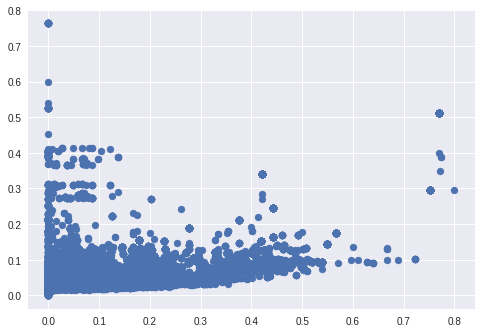

In [ ]:
df['shift'] = np.where(df['Hora planificación'].dt.hour>= 15, "A", "M")
import scipy.stats as ss
r, pVal = ss.pearsonr(df['partner_exposure'], df['leader'])
print("Correlation between 'partner exposure' and 'leader familiarity' = {:.3f} (p-value = {})".format(r,pVal))
plt.scatter(x=df['leader'], y=df['partner_exposure']);

# Correlation Matrix

In [ ]:
np.round(df[['partner_exposure', 'leader', 'team', 'team_size', 'surgeon_experience', 'nr_females', 'cirujano_ayudante_familiarity', 'gender_diversity']].corr(),2).to_csv('/content/corr.csv')

In [ ]:
corrMatrix = np.round(df[['partner_exposure', 'leader', 'team', 'team_size', 'surgeon_experience', 'nr_females', 'cirujano_ayudante_familiarity', 'gender_diversity']].corr(),2)
corrMatrix.iloc[0,1] = 0.41
corrMatrix.iloc[0,2] = 0.52
corrMatrix.iloc[1,0] = 0.41
corrMatrix.iloc[2,0] = 0.52
corrMatrix
mask = np.zeros_like(corrMatrix)
dfAux = corrMatrix.copy(deep=True)
for i in range(len(corrMatrix)):
  col = corrMatrix.index[i]
  print("Mean col {} = {} = {:.2f}".format(i, col , df[col].mean()))
  #corrMatrix.iloc[i,i] = np.nan
  dfAux.iloc[i,i] = df[col].mean()
  mask[i,i] = True

Mean col 0 = partner_exposure = 0.09
Mean col 1 = leader = 0.15
Mean col 2 = team = 210.28
Mean col 3 = team_size = 3.21
Mean col 4 = surgeon_experience = 403.08
Mean col 5 = nr_females = 1.62
Mean col 6 = cirujano_ayudante_familiarity = 10.78
Mean col 7 = gender_diversity = 0.36


In [ ]:
np.round(df[['partner_exposure', 'leader', 'team', 'team_size', 'surgeon_experience', 'nr_females', 'cirujano_ayudante_familiarity', 'gender_diversity']].agg(['mean','std']),2).to_csv('/content/stats.csv')

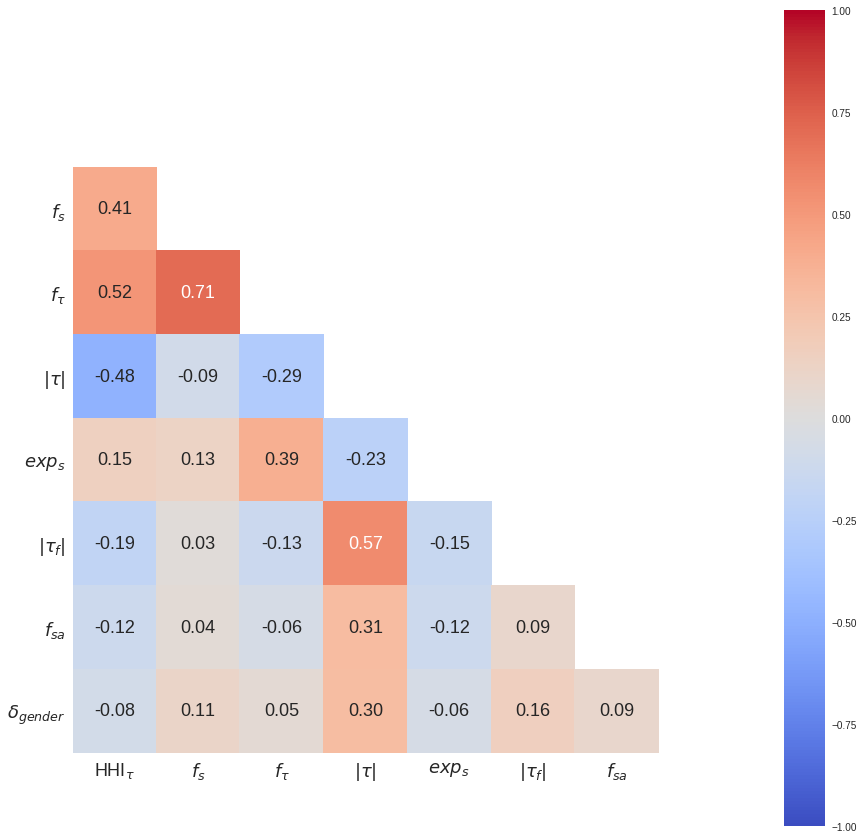

In [ ]:
import seaborn as sns
fs = 18
x_labels = [r'HHI$_\tau$', r'$f_s$', r'$f_\tau$', r'$ |\tau|$', r'$exp_s$', r'$|\tau_f|$', r'$f_{sa}$', '']
y_labels = ['', r'$f_s$', r'$f_\tau$', r'$ |\tau|$', r'$exp_s$', r'$|\tau_f|$', r'$f_{sa}$', r'$\delta_{gender}$']
mask[np.triu_indices(len(mask))] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    #ax = sns.heatmap(corrMatrix, mask=mask, vmin=-1, vmax=1, annot=dfAux, square=True, annot_kws={'fontsize':fs}, xticklabels=labels, yticklabels=labels)
    ax = sns.heatmap(corrMatrix, mask=mask,vmin=-1, vmax=1, annot=dfAux, square=True, annot_kws={'fontsize':fs}, xticklabels=x_labels, yticklabels=y_labels, fmt='.2f', cmap = 'coolwarm')

plt.yticks(fontsize=fs, rotation=0)
#ax.xaxis.set_ticks_position('top')
plt.xticks(fontsize=fs, rotation=0);


# Baseline MAE

In [ ]:
dfAux = df.dropna(subset=['avg_surgeon'])
baseline_mae_surgeon = np.mean(np.abs(dfAux['or_time'] - dfAux['avg_surgeon']))
baseline_mae_OMC = np.mean(np.abs(dfAux['or_time'] - dfAux['avg_OMC']))
print("Dataset with {} rows and {} columns.".format(dfAux.shape[0], dfAux.shape[1]))
print("Baseline MAEs :")
print("\t Using Surgeon Averages = {:.3f}".format(baseline_mae_surgeon))
print("\t Using OMC Averages = {:.3f}".format(baseline_mae_OMC))

Dataset with 17721 rows and 55 columns.
Baseline MAEs :
	 Using Surgeon Averages = 18.976
	 Using OMC Averages = 32.320


In [ ]:
dfAux[['avg_surgeon', 'avg_OMC']].agg(['mean', 'std'])

,avg_surgeon,avg_OMC
mean,57.337021,68.674420
std,61.510451,107.088669


# Data Reshaping

* DV: ``or_time``
* IV: See list below in ``features``.

In [ ]:
#features = ['or_time', 'Especialidad', 'Intervención (Cod. OMC)','Grupo OMC', 'Quirófano','Tipo', 'Urgente', 'AP', 'Cirujano', 'Anestesista', 'Ayudante', 'Instrumentista', 'Circulante', 'Auxiliar', 
#            'leader', 'team', 'team_size', 'partner_exposure', 'surgeon_experience', 'shift', 'dow', 'avg_OMC', 'avg_surgeon', 'gender_Cirujano', 'nr_females', 'cirujano_ayudante_familiarity']
features = ['or_time', 'Especialidad', 'Intervención (Cod. OMC)','Grupo OMC', 'Quirófano','Tipo', 'Urgente', 'AP', 'Cirujano',
            'leader', 'team', 'team_size', 'partner_exposure', 'surgeon_experience', 'shift', 'dow', 'avg_OMC', 'avg_surgeon', 
            'gender_Cirujano', 'nr_females', 'cirujano_ayudante_familiarity', 'same_gender']


In [ ]:
df_ml = dfAux[features]
print("After dropping unused columns, the ML dataset is of size {} x {}.".format(df_ml.shape[0], df_ml.shape[1]))

After dropping unused columns, the ML dataset is of size 17721 x 22.


Let us see if we can group together some of the categories: For each categorical variable, if a certain level has less than 50 observations, we add such level to a generic ``Others``.

We want to remove observations for which certain **important** criteria are not satisfied:
* Value in a set of columns is not know, e.g., cirujano, especialidad, código OMC, etc. If a value is missing in any of these columns, we drop the row.
* ``or_time`` < 10 minutes
* ``or_time`` > 600 minutes (there is only one observation with duration 1515 minutes, i.e., observation number 5386)

In [ ]:
df_ml = df_ml.dropna(subset=['Especialidad', 'Intervención (Cod. OMC)','Grupo OMC','Cirujano', 'avg_OMC', 'avg_surgeon'])
print("After dropping na, the size is {}.".format(df_ml.shape))
df_ml = df_ml[(df_ml['or_time'] > 10) & (df_ml['or_time'] <= 600)]
print("After dropping short interventions, the size is {}.".format(df_ml.shape))

After dropping na, the size is (17013, 22).
After dropping short interventions, the size is (14576, 22).


In [ ]:
baseline_mae_surgeon = np.mean(np.abs(df_ml['or_time'] - df_ml['avg_surgeon']))
baseline_mae_OMC = np.mean(np.abs(df_ml['or_time'] - df_ml['avg_OMC']))
print("Dataset with {} rows and {} columns.".format(df_ml.shape[0], df_ml.shape[1]))
print("Baseline MAEs :")
print("\t Using Surgeon Averages = {:.3f}".format(baseline_mae_surgeon))
print("\t Using OMC Averages = {:.3f}".format(baseline_mae_OMC))

Dataset with 14576 rows and 22 columns.
Baseline MAEs :
	 Using Surgeon Averages = 21.175
	 Using OMC Averages = 37.302


The next chunk allows to shrink the number of categories in the categorical variables. The rationale is as follows:
* Some of the levels of the categorical variables are underrepresented. We might want to group them into a generic group ``others``.
* We fix a threshold value (e.g., minimum 50 observations) and all the levels with less than the threshold number of observations are grouped together into the category ``others``.

In [ ]:
withOthers = True
if withOthers:
  threshold = 10
  #cols = ['Cirujano', 'Anestesista', 'Ayudante', 'Instrumentista', 'Circulante', 'Auxiliar', 'Intervención (Cod. OMC)', 'Especialidad']
  cols = ['Cirujano', 'Intervención (Cod. OMC)', 'Especialidad']

  for col in cols:
    name_col = 'new_' + col 
    df_ml[col] = np.where(pd.isnull(df_ml[col]), 'others', df_ml[col])
    others = df_ml[col].value_counts().to_dict()
    df_ml[name_col] = ['others' if others[df_ml[col].iloc[i]] < threshold else df_ml[col].iloc[i] for i in range(df_ml.shape[0])]
    print("Column {} has {} others.".format(name_col, (df_ml[name_col].values == 'others').sum()))

  # recategorization of categorical variables (drop old and keep new)
  print("Before dropping old columns, size is ", df_ml.shape)
  df_ml = df_ml.drop(columns=cols)
  print("Afer dropping old columns, size is ", df_ml.shape)


Column new_Cirujano has 150 others.
Column new_Intervención (Cod. OMC) has 927 others.
Column new_Especialidad has 0 others.
Before dropping old columns, size is  (14576, 25)
Afer dropping old columns, size is  (14576, 22)


## Create Dummy Variables

We create binary variables for each categorical, considering the following:
* If a categorical variable has $k$ levels, we create $k-1$ binary variables (using the flag ``drop_first=True`` in the function)
* We keep all the numerical variables as they are and we copy only the binary variables (the original categorical variables should be removed from the dataset.)

In [ ]:
# get numerical variables
df_dummy = df_ml[[col for col in df_ml if df_ml[col].dtype != object]]
print("Numerical colums are {}".format(df_dummy.columns))

# transform categorical variables (note: k-1 binary variables)
for col in df_ml.columns:
  if df_ml[col].dtype == 'object':
     #print("Col {} is of type {}".format(col, df_ml[col].dtype))
    dummy = pd.get_dummies(df_ml[col], drop_first=True, prefix=col, prefix_sep='_')
    df_dummy = pd.concat([df_dummy, dummy], axis = 1)
    #print("Now cols are ", df_dummy.columns)

df_ml = df_dummy
print("Dataset with binary variables is of size {}".format(df_ml.shape))
df_ml.head(2)

Numerical colums are Index(['or_time', 'leader', 'team', 'team_size', 'partner_exposure',
       'surgeon_experience', 'avg_OMC', 'avg_surgeon', 'nr_females',
       'cirujano_ayudante_familiarity', 'same_gender'],
      dtype='object')
Dataset with binary variables is of size (14576, 347)


,or_time,leader,team,team_size,partner_exposure,surgeon_experience,avg_OMC,avg_surgeon,nr_females,cirujano_ayudante_familiarity,same_gender,Grupo OMC_Grupo I,Grupo OMC_Grupo II,Grupo OMC_Grupo III,Grupo OMC_Grupo IV,Grupo OMC_Grupo V,Grupo OMC_Grupo VI,Grupo OMC_Grupo VII,Grupo OMC_Grupo VIII,Grupo OMC_Intervenciones Obstetricas,Grupo OMC_Otros Actos Quirurgicos,Quirófano_Intervencionismo,Quirófano_Quirofano 1,Quirófano_Quirofano 10,Quirófano_Quirofano 11,Quirófano_Quirofano 12,Quirófano_Quirofano 2,Quirófano_Quirofano 3,Quirófano_Quirofano 4,Quirófano_Quirofano 5,Quirófano_Quirofano 6,Quirófano_Quirofano 7,Quirófano_Quirofano 8,Quirófano_Quirofano 9,Quirófano_Quirófano A,Quirófano_Quirófano B,Tipo_CCI,Urgente_SI,AP_SI,shift_M,...,new_Intervención (Cod. OMC)_ROTURA TENDON SUPRAESPINOSO O MANGUITO ROTADORES. TRATAMIENTO POR ARTROSCOPIA,new_Intervención (Cod. OMC)_SEPTOPLASTIA SECUNDARIA,new_Intervención (Cod. OMC)_SINDROME COMPRESIVO DE TUNEL CARPIANO. TRATAMIENTO QUIRURGICO,"new_Intervención (Cod. OMC)_SINOVECTOMIAS (CADERA, RODILLA). TRATAMIENTO QUIRURGICO O POR ARTROSCOPIA",new_Intervención (Cod. OMC)_TORACOSTOMIA,new_Intervención (Cod. OMC)_TUMOR DE PARPADO. EXTIRPACION CON PLASTIA LOCAL,new_Intervención (Cod. OMC)_TUMOR MALIGNO CUTANEO. EXTIRPACION QUIRURGICA Y CIERRE DIRECTO,new_Intervención (Cod. OMC)_TUMOR MALIGNO CUTANEO. EXTIRPACION QUIRURGICA Y COLGAJO,new_Intervención (Cod. OMC)_TUMOR O QUISTE PALPEBRAL. EXTIRPACION SIMPLE,new_Intervención (Cod. OMC)_TUMOR PARTES BLANDAS PROFUNDAS. EXTIRPACION,new_Intervención (Cod. OMC)_TUMORACION DE PARTES BLANDAS PROFUNDAS. EXTIRPACION,new_Intervención (Cod. OMC)_TUMORECTOMIA DE MAMA,"new_Intervención (Cod. OMC)_TUMORES BENIGNOS CUTANEOS (QUISTE EPIDERMICO, NEVUS, LIPOMAS, ANGIOMAS, ETC.) (UNA O VARIAS LESIONES). EXTIRPACION","new_Intervención (Cod. OMC)_TUMORES BENIGNOS DE CONJUNTIVA ( PTERIGION, PINGUECULA, ETC.). TRATAMIENTO QUIRURGICO",new_Intervención (Cod. OMC)_TUMORES CUTANEOS CARA Y CUELLO. EXTIRPACION QUIRURGICA Y CIERRE DIRECTO,new_Intervención (Cod. OMC)_TUMORES CUTANEOS DE CARA Y CUELLO. EXTIRPACION Y COLGAJO CUTANEO,new_Intervención (Cod. OMC)_VACIAMIENTO PETROMASTOIDEO CON COMPLICACIONES CEREBRALES VENOSAS O LABERINTICAS,new_Intervención (Cod. OMC)_VAPORIZACION PROSTATA CON LASER VERDE (KTP),new_Intervención (Cod. OMC)_VARICES. FLEBOEXTRACCION DE VENAS SAFENAS INTERNA Y EXTERNA,new_Intervención (Cod. OMC)_VASECTOMIA BILATERAL,new_Intervención (Cod. OMC)_VITRECTOMIA,new_Intervención (Cod. OMC)_others,new_Especialidad_CIRUGÍA CARDIOVASCULAR,new_Especialidad_CIRUGÍA GENERAL Y DEL APARATO DIGESTIVO,new_Especialidad_CIRUGÍA MAXILOFACIAL,new_Especialidad_CIRUGÍA PEDIÁTRICA,new_Especialidad_CIRUGÍA PLÁSTICA Y REPARADORA,new_Especialidad_CIRUGÍA TORÁCICA,new_Especialidad_CIRUGÍA VASCULAR,new_Especialidad_DERMATOLOGÍA,new_Especialidad_DIGESTIVO,new_Especialidad_ENDOSCOPIAS,new_Especialidad_NEUMOLOGÍA,new_Especialidad_NEUROCIRUGÍA,new_Especialidad_OBSTETRICIA Y GINECOLOGÍA,new_Especialidad_OFTALMOLOGÍA,new_Especialidad_OTORRINOLARINGOLOGÍA,new_Especialidad_TRATAMIENTO DEL DOLOR,new_Especialidad_TRAUMATOLOGÍA Y CIRUGÍA ORTOPÉDICA,new_Especialidad_UROLOGÍA
0,13,0.000000,0.0,2,0.308160,957,21.306165,21.269190,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,85,0.070588,43.5,4,0.067136,286,494.483112,180.096774,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Training vs Testing

In [ ]:
train_dataset = df_ml.sample(frac=0.8,random_state=0)
#train_dataset = df_ml.sample(frac=0.8)

test_dataset = df_ml.drop(train_dataset.index)
print("Training dataset size \t= {:5d} x {}.".format(train_dataset.shape[0], train_dataset.shape[1]))
print("Testing dataset size \t= {:5d} x {}.".format(test_dataset.shape[0], test_dataset.shape[1]))

Training dataset size 	= 11661 x 347.
Testing dataset size 	=  2915 x 347.


In [ ]:
#import pickle
%%time
with open('/content/drive/MyDrive/research/health/or/data_HLA/data/data_ml.pkl', 'wb') as f:
  pickle.dump(df_ml, f)
with open('/content/drive/MyDrive/research/health/or/data_HLA/data/data_training.pkl', 'wb') as f:
  pickle.dump(train_dataset, f)
with open('/content/drive/MyDrive/research/health/or/data_HLA/data/data_testing.pkl', 'wb') as f:
  pickle.dump(test_dataset, f)

CPU times: user 12.4 ms, sys: 9.53 ms, total: 22 ms
Wall time: 75.8 ms


In [ ]:
train_dataset.to_csv('/content/drive/MyDrive/research/health/or/data_HLA/data/data_training.csv', index=False)
test_dataset.to_csv('/content/drive/MyDrive/research/health/or/data_HLA/data/data_testing.csv', index=False)

## Data Normalization

Team score is of a different magnitude compared with label score. We normalize both. We also normalize `team_size`. Note that the normalization of both the training and testing data is done using the mean and stdeve of the **training** dataset.

In [ ]:
#train_dataset, log_train_labelstrain_dataset, log_train_labelsnormed_train_data = train_dataset
#normed_test_data = test_dataset
#cols = ['leader', 'team', 'team_size', 'partner_exposure',	'surgeon_experience'] 
#for col in cols:
#  normed_train_data[col] = (train_dataset[col] - train_dataset[col].mean())/train_dataset[col].std()
#  normed_test_data[col] = (test_dataset[col] - train_dataset[col].mean())/train_dataset[col].std()
#
#train_stats = normed_train_data[cols].describe()
##train_stats.pop("or_time")
#train_stats = train_stats.transpose()
#train_stats


## Separate DV from IVs

In [ ]:
train_labels = train_dataset.pop('or_time')
test_labels = test_dataset.pop('or_time')

# Regression

## Original DV - Legacy

This regression model has been abandoned, since it does not account for the skew the the times. The Log Transformed model performs better and is more interpretable.

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1, normalize=True)

# Train the model using the training sets
regr.fit(train_dataset, train_labels)
print("R^2 on Training Data :: {:.3f}".format(regr.score(train_dataset, train_labels)))


R^2 on Training Data :: 0.764


In [ ]:
y_pred = regr.predict(test_dataset)
y_test = test_labels

print("R^2 on Testing Data: \t\t{:.3f}".format(regr.score(test_dataset, test_labels)))
print('Mean Absolute Error: \t\t{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: \t\t{:.3f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: \t{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

R^2 on Testing Data: 		-287499249233787311095808.000
Mean Absolute Error: 		607524183306.312
Mean Squared Error: 		1075884621013304447697158144.000
Root Mean Squared Error: 	32800680191320.797


### Debugging

In [ ]:
#this is no longer needed (used to spot wrong forecasts)
outlier_pred = [i for i in range(len(y_pred)) if ((y_pred[i] < 0.0) | (y_pred[i] > 600))]
idx = y_test.index[outlier_pred]
dfAux.loc[idx][:3]
test_dataset.loc[idx].to_excel('/content/drive/MyDrive/research/health/or/data_HLA/temp2.xlsx', index=True)
test_dataset.loc[idx][:3]

In [ ]:
pos = y_test.index[outlier_pred[0]]
print("Looking for test observation in with index {}.".format(pos))
print("Verify correct selection of 'unusual' forecasts:: {}".format(regr.predict(pd.DataFrame(test_dataset.loc[pos]).transpose())))
print("Corresponding forecasted value = {}".format(y_pred[outlier_pred[0]]))
for col in test_dataset.columns:
  temp_test_dataset = test_dataset.copy(deep=True)
  if test_dataset.loc[pos][col] > 0.0:
    print("Setting to zero var {} whose value is {}.".format(col, test_dataset.loc[pos][col]))
    temp_test_dataset.at[pos, col] = 0.0
    #temp_test_dataset.loc[idx][:3]
    print("Forecast after setting to zero variable {} :: {}".format(col, regr.predict(pd.DataFrame(temp_test_dataset.loc[pos]).transpose())))

Looking for test observation in with index 929.
Verify correct selection of 'unusual' forecasts:: [3.07059845]
Corresponding forecasted value = 21.554798294212194


### Analysis of Regression Coefficients

In [ ]:
cc = pd.DataFrame(regr.intercept_, index=['intercept'], columns=['Coefficients'])
coefs = pd.DataFrame(regr.coef_, columns=['Coefficients'], index=train_dataset.columns)
coefs = pd.concat([cc,coefs], axis=0)
coefs.to_excel('/content/drive/My Drive/research/health/or/data_HLA/results/coefs.xlsx')
coefs.describe()

,Coefficients
count,3.470000e+02
mean,-2.977081e+12
std,1.583975e+14
min,-1.770933e+15
25%,-9.034106e+00
50%,6.805403e+00
75%,2.245783e+01
max,1.770933e+15


** Median Absolute Error on training set: 	8.56 minutes.
** Mean Absolute Error on training set: 	16.95 minutes.

++ Median Absolute Error on testing set: 	8.42 minutes.
++ nMedian Absolute Error on testing set: 	607524183306.31 minutes.


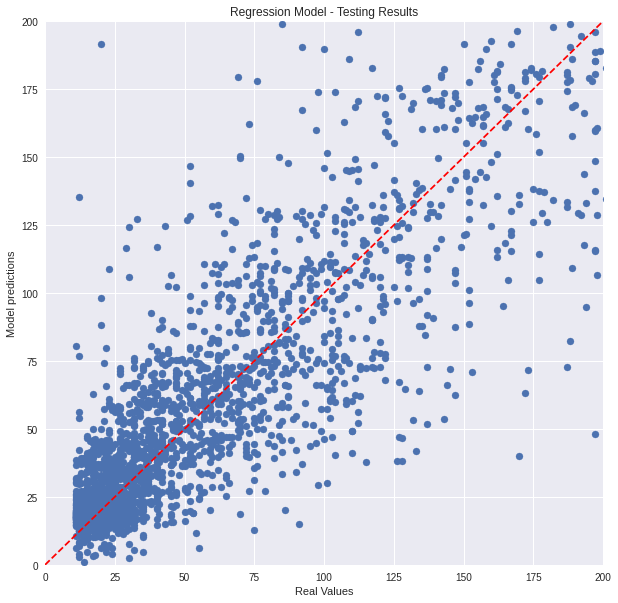

In [ ]:
y_pred = regr.predict(train_dataset)
mae = metrics.median_absolute_error(train_labels, y_pred)
print(f'** Median Absolute Error on training set: \t{mae:.2f} minutes.')
Mae = metrics.mean_absolute_error(train_labels, y_pred)
print(f'** Mean Absolute Error on training set: \t{Mae:.2f} minutes.')


y_pred = regr.predict(test_dataset)
y_test = test_labels
mae = metrics.median_absolute_error(y_test, y_pred)
print(f'\n++ Median Absolute Error on testing set: \t{mae:.2f} minutes.')
Mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'++ nMedian Absolute Error on testing set: \t{Mae:.2f} minutes.')


fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title('Regression Model - Testing Results')
plt.ylabel('Model predictions')
plt.xlabel('Real Values')
plt.xlim([0, 200])
_ = plt.ylim([0, 200])

In [ ]:
coefs.sort_values(by='Coefficients',ascending=False)

,Coefficients
Grupo OMC_Intervenciones Obstetricas,1.770933e+15
new_Especialidad_CIRUGÍA TORÁCICA,7.747736e+14
new_Especialidad_CIRUGÍA VASCULAR,3.003300e+14
"new_Cirujano_reyes burneo, pablo marcelo",2.038163e+14
"new_Cirujano_granell navarro, jose",2.038163e+14
...,...
"new_Cirujano_garcia-prieto bayarri, mª victoria",-3.133614e+14
"new_Cirujano_bernal bernal, cristina",-3.133614e+14
"new_Cirujano_rubio montaña, maria",-3.133614e+14
"new_Cirujano_vazquez pelillo, juan carlos",-7.878051e+14


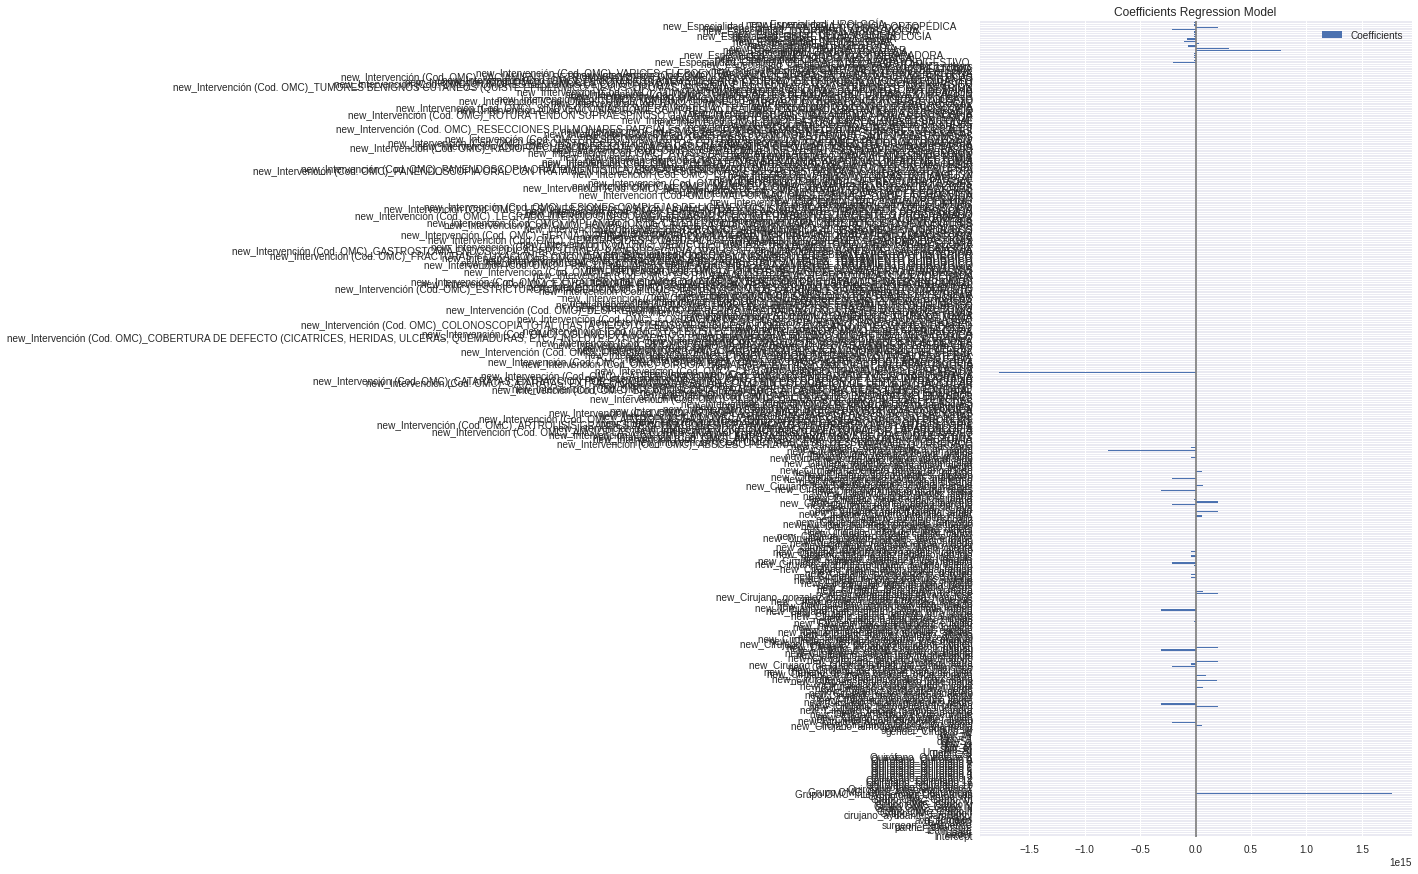

In [ ]:
coefs.plot(kind='barh', figsize=(10, 15))
plt.title('Coefficients Regression Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [ ]:
train_dataset.std(axis=0)

leader                                                         0.177868
team                                                         438.353331
team_size                                                      0.859217
partner_exposure                                               0.104304
surgeon_experience                                           634.363057
                                                                ...    
new_Especialidad_OFTALMOLOGÍA                                  0.342904
new_Especialidad_OTORRINOLARINGOLOGÍA                          0.103795
new_Especialidad_TRATAMIENTO DEL DOLOR                         0.259689
new_Especialidad_TRAUMATOLOGÍA Y CIRUGÍA ORTOPÉDICA            0.242256
new_Especialidad_UROLOGÍA                                      0.248499
Length: 346, dtype: float64

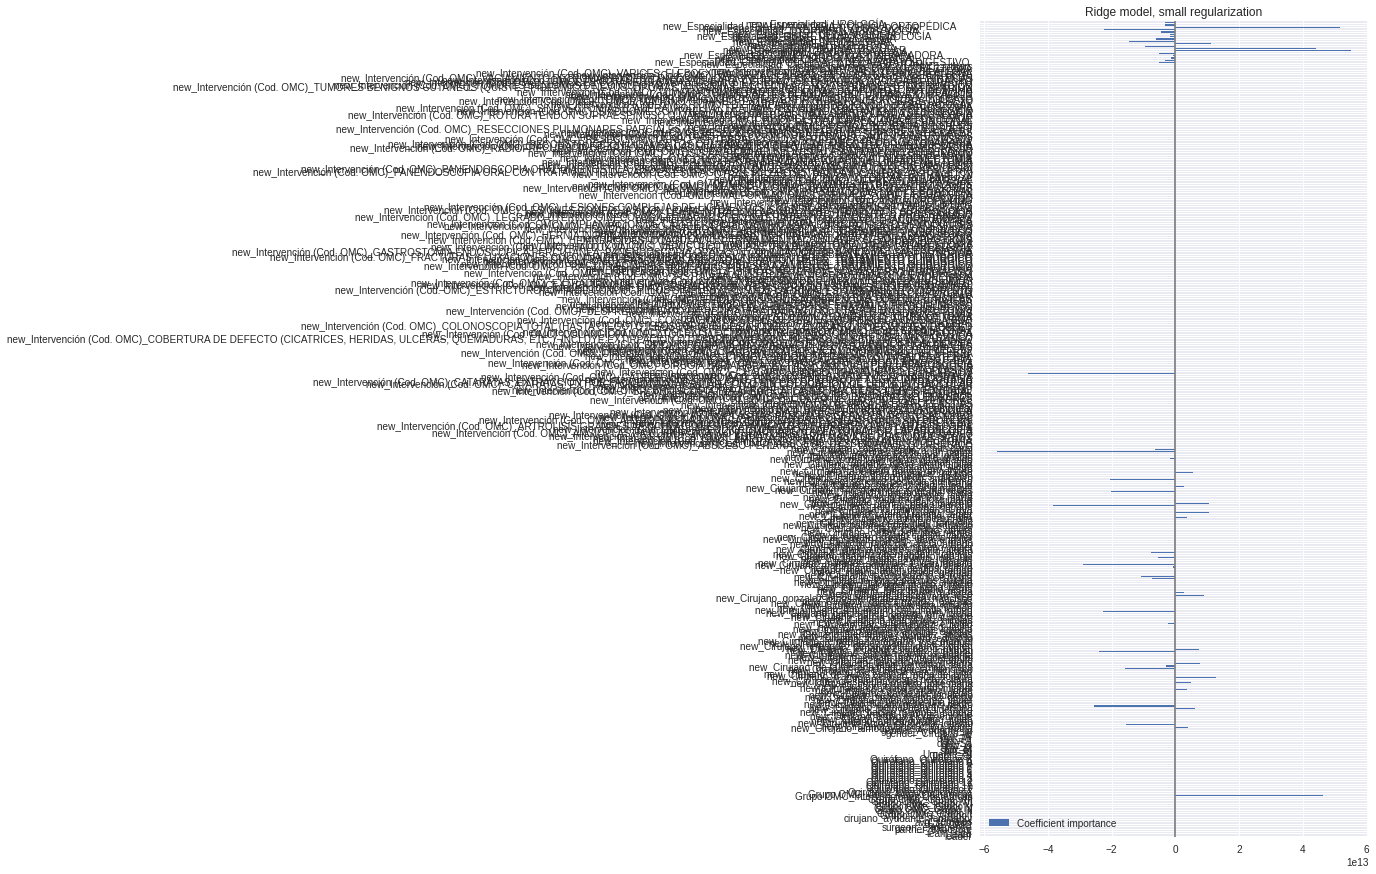

In [ ]:
coefs = pd.DataFrame(
   regr.coef_ * train_dataset.std(axis=0),
    columns=['Coefficient importance'], index=train_dataset.columns
)
coefs.plot(kind='barh', figsize=(9, 15))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Log Transformed Data (DV)

Let us now try to transform the DV, to account for skewness.


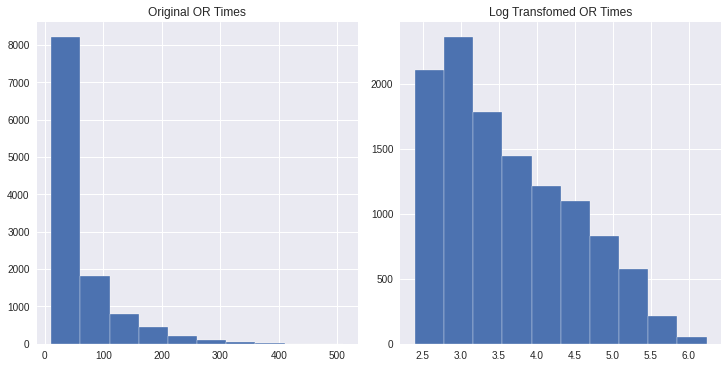

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10,5))
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
fig.add_subplot(gs[0, 0])
plt.hist(train_labels, edgecolor='white')
plt.title("Original OR Times");

log_train_labels = np.log(train_labels)
log_test_labels = np.log(test_labels)
fig.add_subplot(gs[0, 1])
plt.hist(log_train_labels, edgecolor='white')
plt.title("Log Transfomed OR Times");


In [ ]:
# Create linear regression object
regrTypes = ['linear', 'ridge', 'lasso', 'lassoCV', 'bayesianRidge', 'huber']
regression_type = regrTypes[1]

if regression_type == 'linear':
  regr = linear_model.LinearRegression(n_jobs=-1, normalize=False)
elif regression_type == 'ridge':
  regr = linear_model.Ridge(alpha=0.5, normalize=False)
elif regression_type == 'lasso':
  regr = linear_model.Lasso(alpha=0.0001, normalize=False)
elif regression_type == 'lassoCV':
  alpha_list = np.arange(0.0001,1,0.1)
  regr = linear_model.LassoCV(alphas=alpha_list, cv= 10, normalize=False, n_jobs=-1)
elif regression_type == 'bayesianRidge':
  regr = linear_model.BayesianRidge()
elif regression_type == 'huber':
  regr = linear_model.HuberRegressor(epsilon=1.1, max_iter=2000)

# fitting the model
model = regr.fit(train_dataset, log_train_labels)

# Train the model using the training sets
print("Regression Model :: ", model)
print("*"*19)
print("R^2 on Training Data: \t {:.3f}".format(regr.score(train_dataset, log_train_labels)))

y_pred = np.exp(regr.predict(test_dataset))
y_test = test_labels


print("R^2 on Testing Data: \t {:.3f}".format(regr.score(test_dataset, np.log(test_labels))))
print('Mean Absolute Error: \t {:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: \t {:.3f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

if regression_type == 'lassoCV':
  print("++ Chosen alpha value = ", model.alpha_)


Regression Model ::  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
*******************
R^2 on Training Data: 	 0.801
R^2 on Testing Data: 	 0.795
Mean Absolute Error: 	 16.962
Mean Squared Error: 	 1037.694
Root Mean Squared Error: 32.213


MODEL =  Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


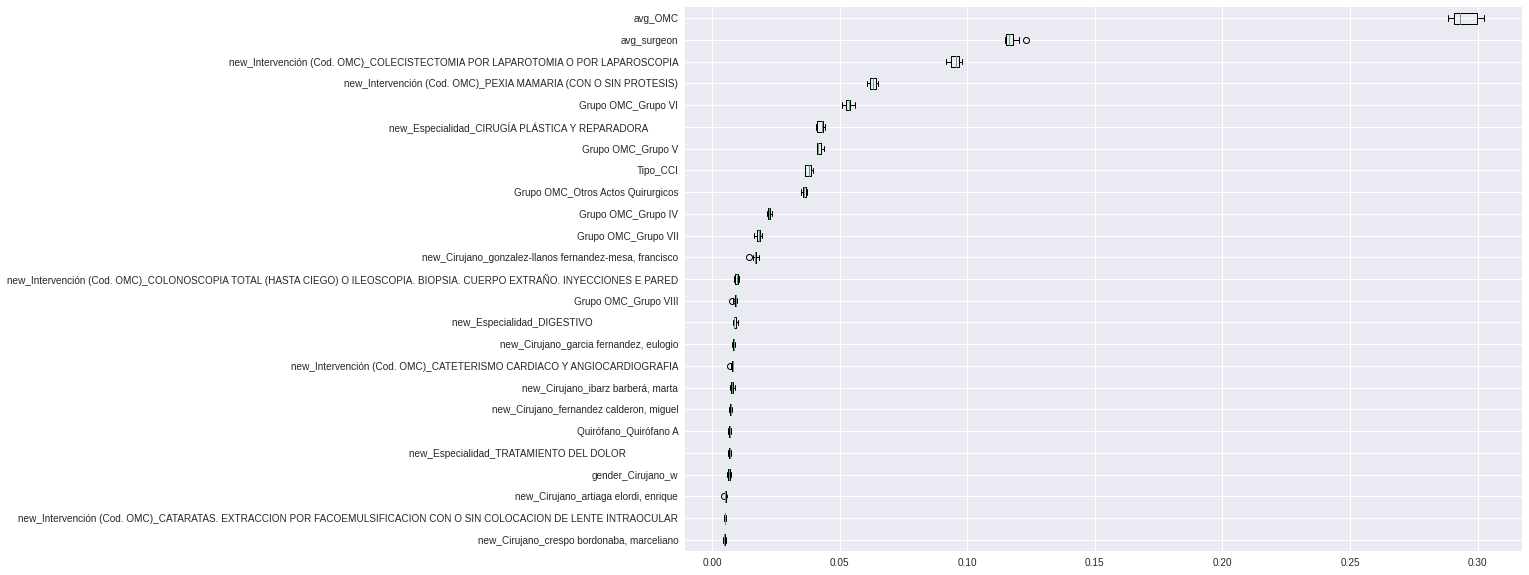

In [ ]:
from sklearn.inspection import permutation_importance
print("MODEL = ", model)

result = model.fit(train_dataset,log_train_labels)
result_importance = permutation_importance(result, train_dataset, log_train_labels, n_repeats=10, random_state=1)

n_top = 25
perm_sorted_idx = result_importance.importances_mean.argsort()[-n_top:]

plt.figure(figsize=(15,10))
plt.boxplot(result_importance.importances[perm_sorted_idx].T, vert=False, 
            labels=train_dataset.columns[perm_sorted_idx]);

### Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor
# Create linear regression object
regr_names = ['linear', 'ridge', 'lasso', 'lassoCV', 'bayesianRidge', 'huber']

regr0 = linear_model.LinearRegression(n_jobs=-1, normalize=False).fit(train_dataset, log_train_labels)
regr1 = linear_model.Ridge(alpha=0.5, normalize=False).fit(train_dataset, log_train_labels)
#regr2 = linear_model.Lasso(alpha=0.01, normalize=False).fit(train_dataset, log_train_labels)
#alpha_list = np.arange(0.0001,1,0.1)
#regr3 = linear_model.LassoCV(alphas=alpha_list, cv= 10, normalize=False, n_jobs=-1).fit(train_dataset, log_train_labels)
#regr4 = linear_model.BayesianRidge().fit(train_dataset, log_train_labels)
#regr5 = linear_model.HuberRegressor(epsilon=1.1, max_iter=2000).fit(train_dataset, log_train_labels)

#vote_regr = VotingRegressor([(regr_names[0], regr0), (regr_names[1], regr1), (regr_names[2], regr2), (regr_names[3], regr3), (regr_names[4], regr4), (regr_names[5], regr5)])
vote_regr = VotingRegressor([(regr_names[0], regr0), (regr_names[1], regr1)])
vote_regr.fit(train_dataset, log_train_labels)
print("Regression Model :: ")
print("*"*19)
print("R^2 on Training Data: \t {:.3f}".format(vote_regr.score(train_dataset, log_train_labels)))

y_pred = np.exp(vote_regr.predict(test_dataset))
y_test = test_labels


print("R^2 on Testing Data: \t {:.3f}".format(vote_regr.score(test_dataset, np.log(test_labels))))
print('Mean Absolute Error: \t {:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: \t {:.3f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))


Regression Model :: 
*******************
R^2 on Training Data: 	 0.917
R^2 on Testing Data: 	 0.913
Mean Absolute Error: 	 15.401
Mean Squared Error: 	 7060.523
Root Mean Squared Error: 84.027


## Save Forecasts to File

In [ ]:
# save results on testing data to file
dfResults = pd.DataFrame({
    'index' : y_test.index,
    'y' : y_test.values,
    'yhat' : y_pred
})
dfResults.head()
dfResults.to_excel('/content/drive/My Drive/research/health/or/data_HLA/results/forecast_w_avgs.xlsx', index=False)

## Cross-validation

In [ ]:
X = df_ml.copy(deep=True)
y_full = X.pop('or_time')
log_y_full = np.log(y_full)

In [ ]:
# define custom score functions

def mae_error(y_true, y_pred):
  """
  We need to use e^y, since we are working with log DV.
  """
  return -metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))
def R2_score(y_true, y_pred):
  ybar = np.mean(y_true)
  SSTot = np.var(y_true, ddof=1)*(len(y_true)-1)
  SSE = sum((y_pred.ravel() - y_true.ravel())**2)
  return (1-SSE/SSTot)

#score = make_scorer(R2_score, greater_is_better=True)
scoring = {'R2' : make_scorer(R2_score, greater_is_better=True),
           'mae' : make_scorer(mae_error, greater_is_better=False)}


n_folds = 5
model = linear_model.LinearRegression(n_jobs=-1, normalize=False)

# using only the training data
#table = cross_validate(model, train_dataset, log_train_labels, cv=n_folds, scoring = scoring, return_train_score=True, verbose=10, n_jobs=1)

# using the entire dataset
table = cross_validate(model, X, log_y_full, cv=n_folds, scoring = scoring, return_train_score=True, verbose=10, n_jobs=1)


print("\n\nSummary Results:: ")
print("Training Avg R^2 :: \t{:10.3f}".format(np.mean(table['train_R2'])))
print("Training Avg neg MAS :: {:10.3f}".format(np.mean(table['train_mae'])))
print("Testing Avg R^2 :: \t{:10.3f}".format(np.mean(table['test_R2'])))
print("Testing Avg neg MAS ::  {:10.3f}\n\n".format(np.mean(table['test_mae'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , R2=(train=0.793, test=0.818), mae=(train=16.523, test=16.293), total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  , R2=(train=0.799, test=0.802), mae=(train=16.233, test=17.010), total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  , R2=(train=0.803, test=0.785), mae=(train=16.302, test=16.541), total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  , R2=(train=0.797, test=0.808), mae=(train=15.970, test=18.145), total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s


[CV]  , R2=(train=0.824, test=0.624), mae=(train=16.137, test=18.295), total=   0.4s


Summary Results:: 
Training Avg R^2 :: 	     0.803
Training Avg neg MAS ::     16.233
Testing Avg R^2 :: 	     0.767
Testing Avg neg MAS ::      17.257




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


## Coefficients Analysis

Analysis based on coefficients of model ``regr``, obtained above.

In [ ]:
cc = pd.DataFrame(regr.intercept_, index=['intercept'], columns=['Coefficients'])
coefs = pd.DataFrame(regr.coef_, columns=['Coefficients'], index=train_dataset.columns)
coefs = pd.concat([cc,coefs], axis=0)
coefs.to_excel('/content/drive/My Drive/research/health/or/data_HLA/results/coefs_log.xlsx')
coefs.describe()

,Coefficients
count,347.000000
mean,0.087504
std,0.338776
min,-3.063810
25%,-0.072268
50%,0.095404
75%,0.231314
max,2.466477


** Median Absolute Error on training set: 	7.16 minutes.
** Mean Absolute Error on training set: 	16.22 minutes.

++ Median Absolute Error on testing set: 	7.00 minutes.
++ nMedian Absolute Error on testing set: 	16.99 minutes.


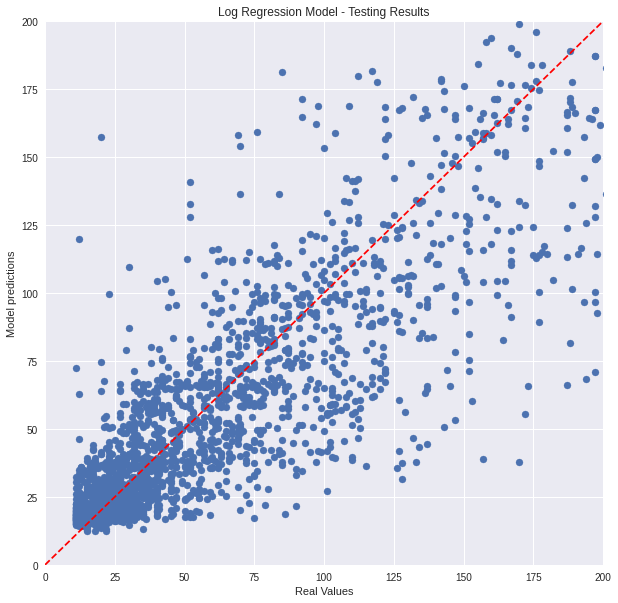

In [ ]:
y_pred = np.exp(regr.predict(train_dataset))
mae = metrics.median_absolute_error(train_labels, y_pred)
print(f'** Median Absolute Error on training set: \t{mae:.2f} minutes.')
Mae = metrics.mean_absolute_error(train_labels, y_pred)
print(f'** Mean Absolute Error on training set: \t{Mae:.2f} minutes.')


y_pred = np.exp(regr.predict(test_dataset))
y_test = test_labels
mae = metrics.median_absolute_error(y_test, y_pred)
print(f'\n++ Median Absolute Error on testing set: \t{mae:.2f} minutes.')
Mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'++ nMedian Absolute Error on testing set: \t{Mae:.2f} minutes.')


fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title('Log Regression Model - Testing Results')
plt.ylabel('Model predictions')
plt.xlabel('Real Values')
plt.xlim([0, 200])
plt.ylim([0, 200]);

In [ ]:
coefs = pd.DataFrame(
   regr.coef_ * train_dataset.std(axis=0),
    columns=['Coefficient_importance'], index=train_dataset.columns
)
subset_coefs = coefs.Coefficient_importance.abs().sort_values(ascending=False).index
coefs.loc[subset_coefs].head(5)

,Coefficient_importance
avg_OMC,0.442890
new_Intervención (Cod. OMC)_COLECISTECTOMIA POR LAPAROTOMIA O POR LAPAROSCOPIA,-0.241663
new_Intervención (Cod. OMC)_PEXIA MAMARIA (CON O SIN PROTESIS),-0.200526
avg_surgeon,0.185334
new_Intervención (Cod. OMC)_COLONOSCOPIA TOTAL (HASTA CIEGO) O ILEOSCOPIA. BIOPSIA. CUERPO EXTRAÑO. INYECCIONES E PARED,0.165848


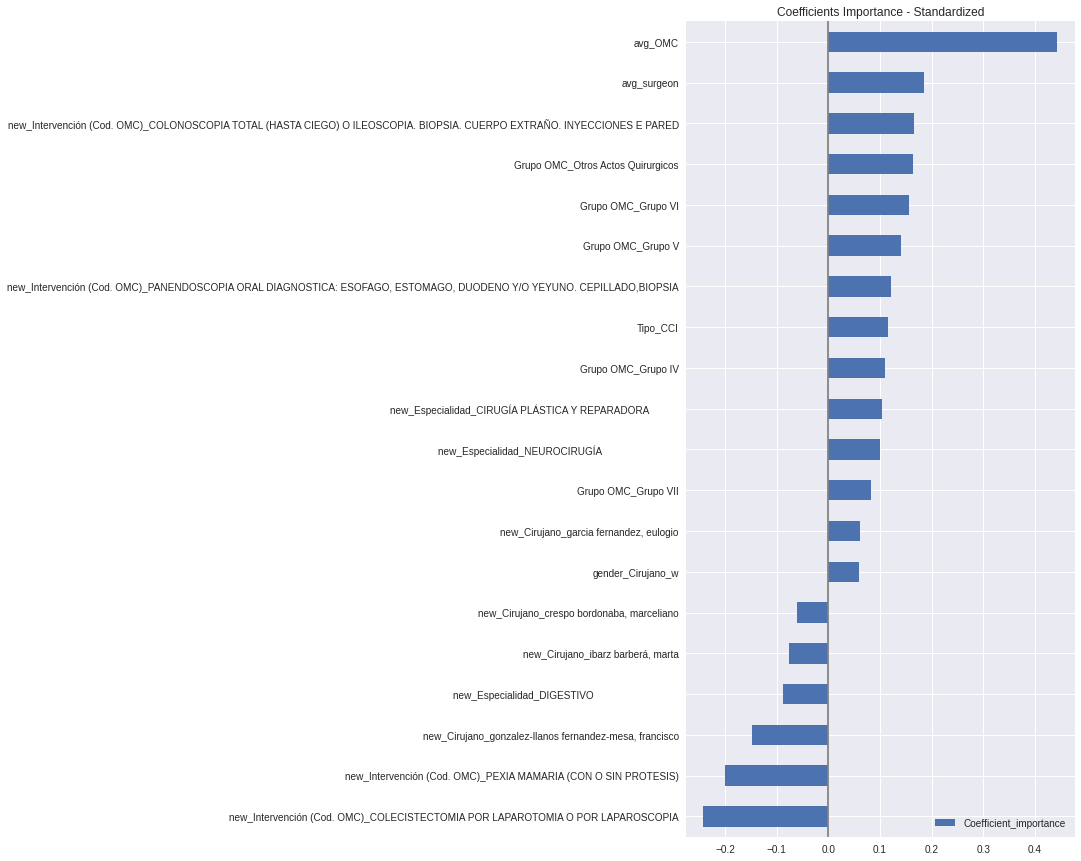

In [ ]:
coefs.loc[subset_coefs].head(20).sort_values(by='Coefficient_importance').plot(kind='barh', figsize=(9, 15))
plt.title('Coefficients Importance - Standardized')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Other ML Approaches

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]

In [ ]:
regressors = [RandomForestRegressor(random_state=1), GradientBoostingRegressor(random_state=1), BaggingRegressor(random_state=1), ExtraTreesRegressor(random_state=1), 
              StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)), HistGradientBoostingRegressor()]
names = ['RandomForestRegressor', 'GradientBoostingRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 'StackingRegressor', 'HistGradientBoostingRegressor']
for name, regressor in zip(names, regressors):
  print("Training {}".format(regressor))
  regr = regressor
  model = regressor

  table = cross_validate(model, X, log_y_full, cv=n_folds, scoring = scoring, return_train_score=True, verbose=10, n_jobs=1)


  print("\n\nSummary Results:: ")
  print("Training Avg R^2 :: \t{:10.3f}".format(np.mean(table['train_R2'])))
  print("Training Avg neg MAS :: {:10.3f}".format(np.mean(table['train_mae'])))
  print("Testing Avg R^2 :: \t{:10.3f}".format(np.mean(table['test_R2'])))
  print("Testing Avg neg MAS ::  {:10.3f}\n\n".format(np.mean(table['test_mae'])))
  
  regr.fit(train_dataset, log_train_labels)

  y_pred = np.exp(regr.predict(test_dataset))
  y_test = test_labels

  mae = metrics.mean_absolute_error(y_test, y_pred)
  print(f'\n++ Mean Absolute Error on testing set: \t{mae:.2f} minutes.')

  

Training RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.941, test=0.817), mae=(train=7.739, test=16.137), total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s remaining:    0.0s


[CV]  , R2=(train=0.943, test=0.801), mae=(train=7.692, test=16.722), total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.5s remaining:    0.0s


[CV]  , R2=(train=0.943, test=0.784), mae=(train=7.786, test=16.677), total=  16.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.5s remaining:    0.0s


[CV]  , R2=(train=0.941, test=0.805), mae=(train=7.609, test=17.853), total=  16.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV]  , R2=(train=0.945, test=0.663), mae=(train=7.839, test=17.318), total=  16.1s


Summary Results:: 
Training Avg R^2 :: 	     0.943
Training Avg neg MAS ::      7.733
Testing Avg R^2 :: 	     0.774
Testing Avg neg MAS ::      16.941




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished



++ Mean Absolute Error on testing set: 	16.94 minutes.
Training GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.798, test=0.822), mae=(train=16.279, test=15.886), total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  , R2=(train=0.802, test=0.807), mae=(train=16.133, test=16.536), total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV]  , R2=(train=0.805, test=0.791), mae=(train=16.123, test=16.353), total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.7s remaining:    0.0s


[CV]  , R2=(train=0.799, test=0.815), mae=(train=15.847, test=17.863), total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.9s remaining:    0.0s


[CV]  , R2=(train=0.825, test=0.691), mae=(train=16.047, test=16.618), total=   6.3s


Summary Results:: 
Training Avg R^2 :: 	     0.806
Training Avg neg MAS ::     16.086
Testing Avg R^2 :: 	     0.785
Testing Avg neg MAS ::      16.651




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.3s finished



++ Mean Absolute Error on testing set: 	16.67 minutes.
Training BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=1, verbose=0,
                 warm_start=False)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.932, test=0.808), mae=(train=8.298, test=16.485), total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  , R2=(train=0.935, test=0.790), mae=(train=8.100, test=17.272), total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV]  , R2=(train=0.935, test=0.769), mae=(train=8.246, test=17.406), total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s


[CV]  , R2=(train=0.933, test=0.790), mae=(train=8.052, test=18.636), total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.4s remaining:    0.0s


[CV]  , R2=(train=0.939, test=0.644), mae=(train=8.300, test=17.763), total=   1.8s


Summary Results:: 
Training Avg R^2 :: 	     0.935
Training Avg neg MAS ::      8.199
Testing Avg R^2 :: 	     0.760
Testing Avg neg MAS ::      17.512




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s finished



++ Mean Absolute Error on testing set: 	17.26 minutes.
Training ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=1, verbose=0, warm_start=False)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.963, test=0.796), mae=(train=2.667, test=17.261), total=  17.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV]  , R2=(train=0.963, test=0.777), mae=(train=2.669, test=17.989), total=  17.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.8s remaining:    0.0s


[CV]  , R2=(train=0.964, test=0.757), mae=(train=2.737, test=17.804), total=  17.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.2s remaining:    0.0s


[CV]  , R2=(train=0.962, test=0.785), mae=(train=2.709, test=18.497), total=  17.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV]  , R2=(train=0.963, test=0.616), mae=(train=2.983, test=18.640), total=  16.0s


Summary Results:: 
Training Avg R^2 :: 	     0.963
Training Avg neg MAS ::      2.753
Testing Avg R^2 :: 	     0.746
Testing Avg neg MAS ::      18.038




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished



++ Mean Absolute Error on testing set: 	18.29 minutes.
Training StackingRegressor(cv=None,
                  estimators=[('lr',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                       cv=None, fit_intercept=True,
                                       gcv_mode=None, normalize=False,
                                       scoring=None, store_cv_values=False)),
                              ('svr',
                               LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                         fit_intercept=True,
                                         intercept_scaling=1.0,
                                         loss='epsilon_insensitive',
                                         max_iter=1000, random_state=42,
                                         tol=0.0001, verbose=0))],
                  final_esti...e,
                                                        ccp_alpha=0.0,
                                

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, 

[CV]  , R2=(train=0.712, test=0.749), mae=(train=19.417, test=18.978), total=  11.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

[CV]  , R2=(train=0.728, test=0.752), mae=(train=18.645, test=18.619), total=  11.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.4s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

[CV]  , R2=(train=0.739, test=0.732), mae=(train=19.022, test=19.662), total=  11.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

[CV]  , R2=(train=0.731, test=0.742), mae=(train=18.384, test=20.998), total=  11.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   47.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

[CV]  , R2=(train=0.776, test=0.550), mae=(train=18.358, test=20.359), total=  11.7s


Summary Results:: 
Training Avg R^2 :: 	     0.737
Training Avg neg MAS ::     18.765
Testing Avg R^2 :: 	     0.705
Testing Avg neg MAS ::      19.723




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn


++ Mean Absolute Error on testing set: 	19.30 minutes.
Training HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.839, test=0.828), mae=(train=14.443, test=15.433), total=   7.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV]  , R2=(train=0.844, test=0.816), mae=(train=14.214, test=16.099), total=   7.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s


[CV]  , R2=(train=0.846, test=0.800), mae=(train=14.164, test=16.075), total=   6.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s


[CV]  , R2=(train=0.842, test=0.819), mae=(train=13.876, test=17.396), total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.3s remaining:    0.0s


[CV]  , R2=(train=0.861, test=0.691), mae=(train=14.099, test=16.542), total=   6.2s


Summary Results:: 
Training Avg R^2 :: 	     0.847
Training Avg neg MAS ::     14.159
Testing Avg R^2 :: 	     0.791
Testing Avg neg MAS ::      16.309




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.5s finished



++ Mean Absolute Error on testing set: 	16.13 minutes.


## Grid Search Cross Validation for Random Forest

In [ ]:
X = df_ml.copy(deep=True)
y_full = X.pop('or_time')
log_y_full = np.log(y_full)

In [ ]:
from pprint import pprint
#RandomForestRegressor(random_state=1, n_jobs=-1, criterion='mse').get_params()
HistGradientBoostingRegressor().get_params()

{'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'least_squares',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'n_iter_no_change': None,
 'random_state': None,
 'scoring': None,
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
l2_regularization = np.arange(0,0.5,0.1)
learning_rate = np.arange(0.01,0.11,0.005)
#loss = ['least_squares', 'least_absolute_deviation']
max_bins = [100, 150, 200, 255]
max_iter = [50, 100, 200, 250]
n_iter_no_change = [20, 30, 50]
#validation_fraction = [0.2]
max_leaf_nodes =[21, 31, 41, 51]

random_grid = {
    'l2_regularization' : l2_regularization, 
    'learning_rate' : learning_rate,
    #'loss' : loss,
    'max_bins' : max_bins,
    'max_iter' : max_iter,
    'n_iter_no_change' : n_iter_no_change,
    'max_leaf_nodes' : max_leaf_nodes
    #'validation_fraction' : validation_fraction
}

In [ ]:
# Number of trees in random forest
n_estimators = np.arange(150,300,50)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = np.arange(80,190,10)
#max_depth = [int(x) for x in np.linspace(, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_leaf = [4,8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': array([ 80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180]),
 'min_samples_leaf': [4, 8, 12],
 'min_samples_split': [2, 5],
 'n_estimators': array([150, 200, 250])}


In [ ]:
def mae_error(y_true, y_pred):
  """
  We need to use e^y, since we are working with log DV.
  """
  return -metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))
def R2_score(y_true, y_pred):
  ybar = np.mean(y_true)
  SSTot = np.var(y_true, ddof=1)*(len(y_true)-1)
  SSE = sum((y_pred.ravel() - y_true.ravel())**2)
  return (1-SSE/SSTot)

score = make_scorer(mae_error, greater_is_better=False)
#scoring = {'R2' : make_scorer(R2_score, greater_is_better=True),
#           'mae' : make_scorer(mae_error, greater_is_better=False)}


In [ ]:
print("[INFO] Tuning Parameters via Grid Search")
#model = RandomForestRegressor(random_state=1, n_jobs=-1, criterion='mse')
model = HistGradientBoostingRegressor(random_state=1, loss='least_squares', validation_fraction=0.2)


#grid = GridSearchCV(model, params, cv=5, scoring = 'neg_mean_absolute_error', verbose=10)
grid = RandomizedSearchCV(model, random_grid, cv=5, scoring = score, verbose=5)
start = time.time()
grid.fit(X, log_y_full)
print("Best score obtained in the search = {}".format(grid.best_score_))
print("Best parameters = {}".format(grid.best_params_))

[INFO] Tuning Parameters via Grid Search
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004, score=17.425, total=   6.9s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004, score=18.079, total=   6.5s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004, score=17.219, total=   6.5s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s


[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004, score=19.584, total=   7.0s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.9s remaining:    0.0s


[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=200, learning_rate=0.039999999999999994, l2_regularization=0.30000000000000004, score=17.244, total=   7.4s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=100, learning_rate=0.01, l2_regularization=0.30000000000000004 
[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=100, learning_rate=0.01, l2_regularization=0.30000000000000004, score=29.185, total=   4.7s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=100, learning_rate=0.01, l2_regularization=0.30000000000000004 
[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=100, learning_rate=0.01, l2_regularization=0.30000000000000004, score=29.771, total=   4.2s
[CV] n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=100, learning_rate=0.01, l2_regularization=0.30000000000000004 
[CV]  n_iter_no_change=20, max_leaf_nodes=51, max_iter=50, max_bins=100, learning_rate=0.01, l2_regularization=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.1min finished


Best score obtained in the search = 28.885392415260405
Best parameters = {'n_iter_no_change': 50, 'max_leaf_nodes': 21, 'max_iter': 50, 'max_bins': 150, 'learning_rate': 0.01, 'l2_regularization': 0.4}


# Tensor Flow

In [ ]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.keras.utils import losses_utils
from keras.callbacks import TensorBoard

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

print("TensorFlow Version = ", tf.__version__)

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tp7ywa2a
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-tp7ywa2a
     |████████████████████████████████| 1.0MB 7.6MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0af7fffde9d304410f808c8752cfe519ba107ca33_-cp37-none-any.whl size=147328 sha256=1b7b908c370809a5b7070d332863b16c5c7971d0a9a416df4954a0d738ec59a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-e8kn467e/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


TensorFlow Version =  2.4.1


In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                #loss=score,
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def mae_error(y_true, y_pred):
  return -metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))

def R2_score(y_true, y_pred):
  ybar = np.mean(y_true)
  SSTot = np.var(y_true, ddof=1)*(len(y_true)-1)
  SSE = sum((y_pred.ravel() - y_true.ravel())**2)
  return (1-SSE/SSTot)

score = make_scorer(R2_score, greater_is_better=True)
#scoring = {'R2' : make_scorer(R2_score, greater_is_better=True),
#          'mae' : make_scorer(mae_error, greater_is_better=False)}


model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                22208     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 26,433
Trainable params: 26,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X = df_ml.copy(deep=True)
y_full = X.pop('or_time')
log_y_full = np.log(y_full)

In [ ]:
EPOCHS = 1000
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(X, y_full, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1310.6389,  mae:21.1355,  mse:1310.6389,  val_loss:959.3612,  val_mae:19.1626,  val_mse:959.3612,  
....................................................................................................
Epoch: 100, loss:808.9786,  mae:15.7155,  mse:808.9786,  val_loss:990.1377,  val_mae:18.3850,  val_mse:990.1377,  
....................................................................................................
Epoch: 200, loss:710.4003,  mae:14.6554,  mse:710.4003,  val_loss:1041.7242,  val_mae:19.4696,  val_mse:1041.7242,  
....................................................................................................
Epoch: 300, loss:630.7159,  mae:13.8087,  mse:630.7159,  val_loss:1139.2096,  val_mae:20.8210,  val_mse:1139.2096,  
....................................................................................................
Epoch: 400, loss:562.7047,  mae:13.1929,  mse:562.7047,  val_loss:1203.7024,  val_mae:21.1689,  val_mse:1203.7024,  
..............

# Tensor Flow Regression

Taken from:
* [https://www.tensorflow.org/tutorials/keras/regression](https://www.tensorflow.org/tutorials/keras/regression)

The dataset ``df_ml`` has been split into training and testing:
* ``train_dataset`` and ``train_labels``
* ``test_dataset`` and ``test_labels``

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(15,7.5))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 25])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
train_dataset_normalized = preprocessing.Normalization()
train_dataset_normalized.adapt(np.array(train_dataset))

# build sequential model
tf_model = tf.keras.Sequential([
                                train_dataset_normalized, 
                                layers.Dense(units=1) #activation function is 'linear' --> akin to multiple linear regression
])
tf_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_7 (Normalizati (None, 498)               997       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 499       
Total params: 1,496
Trainable params: 499
Non-trainable params: 997
_________________________________________________________________


In [ ]:
# configure training procedure
tf_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

Let us try adding hidden non-linear layers.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
                            norm,
                            layers.Dense(8, activation='relu'),
                            layers.Dense(8, activation='relu'),
                            layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

  return model

In [ ]:
tf_model = build_and_compile_model(train_dataset_normalized)

In [ ]:
# run the model
%%time
history = tf_model.fit(
    train_dataset, train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

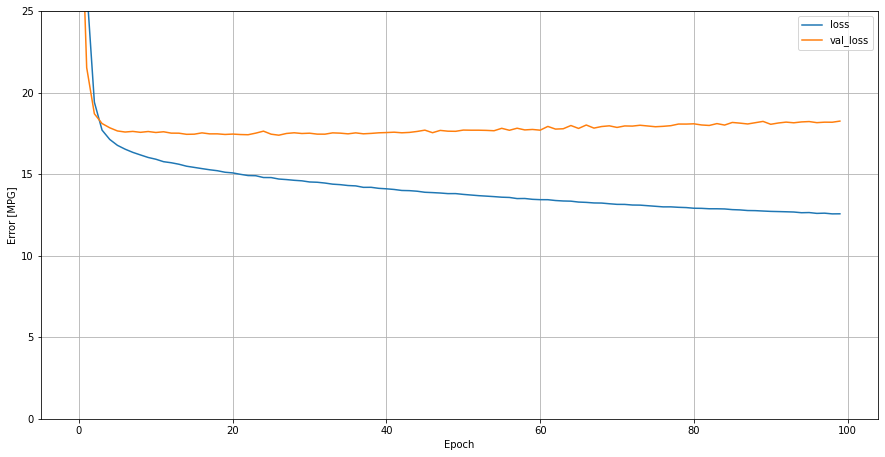

In [ ]:
plot_loss(history)

Let us get the predicted values:

** Median Absolute Error on training set: 	4.87 minutes.
** Mean Absolute Error on training set: 	13.52 minutes.

++ Median Absolute Error on testing set: 	7.61 minutes.
++ nMedian Absolute Error on testing set: 	18.62 minutes.


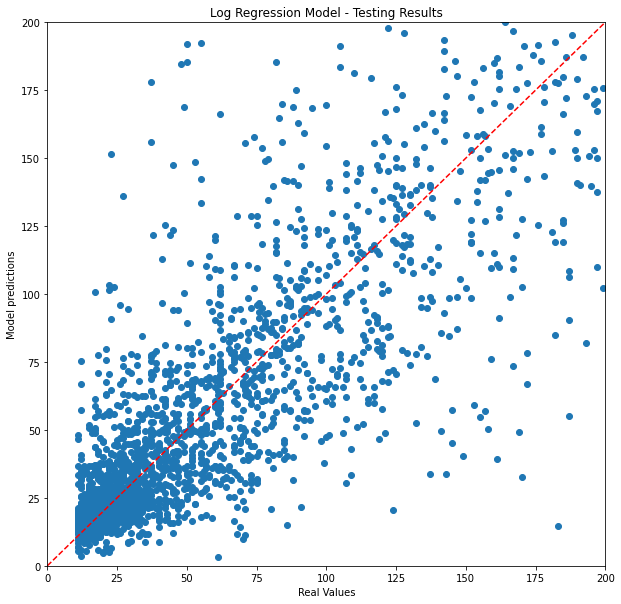

In [ ]:
y_pred = tf_model.predict(train_dataset)

mae = metrics.median_absolute_error(train_labels, y_pred)
print(f'** Median Absolute Error on training set: \t{mae:.2f} minutes.')
Mae = metrics.mean_absolute_error(train_labels, y_pred)
print(f'** Mean Absolute Error on training set: \t{Mae:.2f} minutes.')


y_pred = tf_model.predict(test_dataset)
y_test = test_labels
mae = metrics.median_absolute_error(y_test, y_pred)
print(f'\n++ Median Absolute Error on testing set: \t{mae:.2f} minutes.')
Mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'++ nMedian Absolute Error on testing set: \t{Mae:.2f} minutes.')


fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title('Log Regression Model - Testing Results')
plt.ylabel('Model predictions')
plt.xlabel('Real Values')
plt.xlim([0, 200])
plt.ylim([0, 200]);

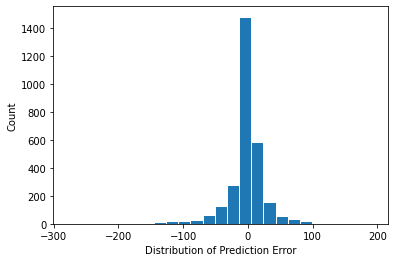

In [ ]:
error = y_pred.flatten() - y_test
plt.hist(error, bins=25, edgecolor='white')
plt.xlabel('Distribution of Prediction Error')
_ = plt.ylabel('Count')

## Addressing Overfitting

* [https://www.tensorflow.org/tutorials/keras/overfit_and_underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

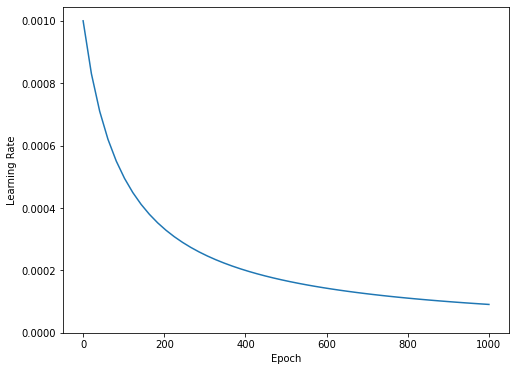

In [ ]:
STEPS_PER_EPOCH = 1
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,1000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(
      optimizer=optimizer, 
      loss='mean_absolute_error',
      metrics=['mean_absolute_error'])

  model.summary()

  history = model.fit(
    train_dataset, train_labels,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=test_dataset_normalized,
    validation_split=0.2,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [ ]:
train_dataset_normalized = preprocessing.Normalization()
train_dataset_normalized.adapt(np.array(train_dataset))

tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(train_dataset.shape[1],)),
    layers.Dense(1)
])
tiny_model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 16)                7984      
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 17        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
size_histories = {}

In [ ]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Optimizer is ***************  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f7bdc5b0908>
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 16)                7984      
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 17        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:57.4866,  mean_absolute_error:57.4866,  val_loss:55.2579,  val_mean_absolute_error:55.2579,  
....................................................................................................
Epoch: 100, loss:36.0198,  mean_absolute_error:36.0198,  val_loss:35.5892,  val_mean_absolute_error:35.5892,  
.......................................................................................

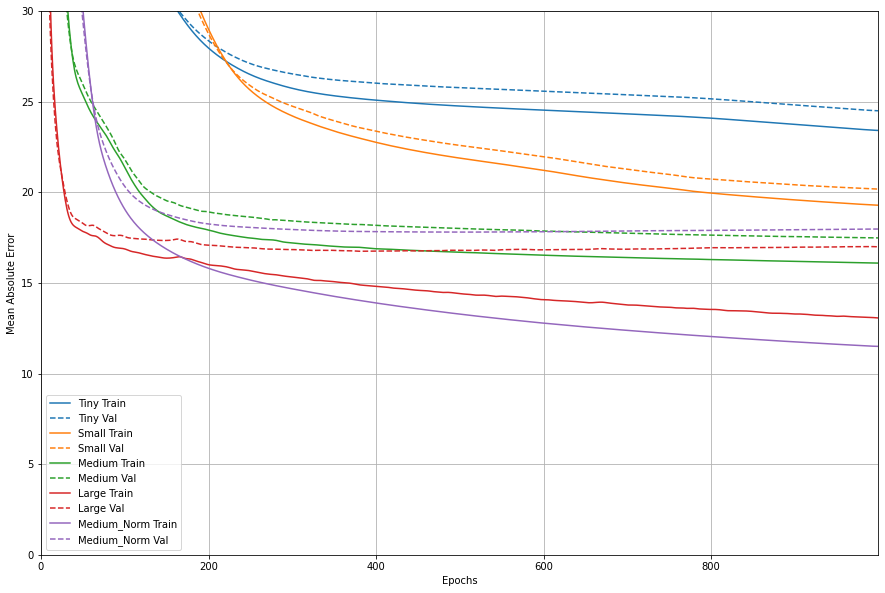

In [ ]:
plt.figure(figsize=(15,10))
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 30]);

In [ ]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='relu', input_shape=(train_dataset.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Optimizer is ***************  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f7bd938f6a0>
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 16)                7984      
_________________________________________________________________
dense_134 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 17        
Total params: 8,273
Trainable params: 8,273
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:70.5692,  mean_absolute_error:70.5692,  val_loss:68.3394,  val_mean_absolute_error:68.3394,  
....................................................................................................
Epoch: 100, loss:41.8436,  mean_absolute_error:41.8436,  val_loss:

In [ ]:
train_dataset_normalized = preprocessing.Normalization()
train_dataset_normalized.adapt(np.array(train_dataset))

test_dataset_normalized = preprocessing.Normalization()
test_dataset_normalized.adapt(np.array(test_dataset))

medium_model = tf.keras.Sequential([
    train_dataset_normalized,            
    layers.Dense(64, activation='relu', input_shape=(train_dataset.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Medium_Norm']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_24 (Normalizat (None, 498)               997       
_________________________________________________________________
dense_149 (Dense)            (None, 64)                31936     
_________________________________________________________________
dense_150 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_151 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 65        
Total params: 41,318
Trainable params: 40,321
Non-trainable params: 997
_________________________________________________________________

Epoch: 0, loss:56.6842,  mean_absolute_error:56.6842,  val_loss:55.5216,  val_mean_absolute_error:55.5216,  
...

In [ ]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(train_dataset.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)
])

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Optimizer is ***************  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f7bcc4e54a8>
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 512)               255488    
_________________________________________________________________
dense_141 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_142 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_143 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 513       
Total params: 1,043,969
Trainable params: 1,043,969
Non-trainable params: 0
_________________________________________________________________

Epoc

## Tune Hyperparameters

We use *hyperband* to fine tune the parameters of the DNN. Taken from:
* [https://keras-team.github.io/keras-tuner/documentation/tuners/](https://keras-team.github.io/keras-tuner/documentation/tuners/)

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(64, activation='relu', input_shape=[train_dataset.shape[1]]))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value = 64, max_value = 512, step =64 )
  hp_units2 = hp.Int('units2', min_value = 64, max_value = 512, step =64 )
  hp_units3 = hp.Int('units3', min_value = 64, max_value = 512, step =64 )

  model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
  model.add(keras.layers.Dense(units = hp_units2, activation = 'relu'))
  model.add(keras.layers.Dense(units = hp_units3, activation = 'relu'))

  model.add(keras.layers.Dense(1))
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), #keras.optimizers.RMSprop(lr_schedule),
                loss = 'mse', 
                metrics = ['mae', 'mse'])
  
  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_mae', 
                     max_epochs = 1000,
                     executions_per_trial = 2,
                     factor = 3,
                     directory = 'my_dir4',
                     project_name = 'kt8')                       

INFO:tensorflow:Reloading Oracle from existing project my_dir4/kt8/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir4/kt8/tuner0.json


In [ ]:
tuner.search(train_dataset, train_labels, epochs = 500, validation_data = (test_dataset, test_labels), callbacks = get_callbacks("tuning"))

# Features Importance

In [ ]:
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

from pprint import pprint

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/research/health/or/data_HLA/data_2019_scores.xlsx')
print("Dataframe with {} rows and {} columns.".format(df.shape[0], df.shape[1]))
df.head()

Dataframe with 20350 rows and 51 columns.


,Unnamed: 0,ID Inter,Especialidad,Fecha Informe,Intervención (Cod. OMC),Grupo OMC,Financiación,Entidad,Autorización,Quirófano,Hora planificación,Hora admisión,Entrada quirófano,Inicio intervención,Fin intervención,Salida quirófano,Tiempo (min.),Tipo,Urgente,AP,Cirujano,Anestesista,Ayudante,Instrumentista,Circulante,Auxiliar,delay_over_planned,time_to_or,idle_or_begin,surgery_time,idle_or_end,or_time,leader,team,team_size,partner_exposure,surgeon_experience,shift,dow,avg_OMC,avg_surgeon,gender_Cirujano,gender_Anestesista,gender_Ayudante,gender_Instrumentista,gender_Circulante,gender_Auxiliar,nr_females,cirujano_ayudante_familiarity,same_gender,gender_diversity
0,0,840528,OBSTETRICIA Y GINECOLOGÍA,2019-03-29 13:24:00,"HISTEROSCOPIA DIAGNOSTICA. BIOPSIA, PEQUEÑOS P...",Grupo 0,Aseguradoras Privadas-ASISA,ASISA,14412921701,Quirofano 4,2019-03-29 11:30:00,2019-03-29 09:54:00,2019-03-29 12:55:00,2019-03-29 13:09:00,2019-03-29 13:19:00,2019-03-29 13:30:00,35.0,AMBULANTE,NO,NO,"tubio echague, jose ignacio","muñoz muñoz, juan francisco","d'angelo velasco, oscar horacio",NaN,fernandez garcia susana,villa rodriguez mª paz,99.0,181.0,14,10,11,35,0.126253,47.900000,5,0.030022,61,M,F,45.524194,42.590164,m,m,m,NaN,w,w,2,61,1,0.480000
1,1,827427,OFTALMOLOGÍA,2019-03-11 12:14:00,CATARATAS. EXTRACCION INTRACAPSULAR CON O SIN ...,Grupo IV,Aseguradoras Privadas-ASISA,ASISA,14297104701,Quirófano A,2019-03-11 11:00:00,2019-03-11 09:50:00,2019-03-11 11:19:00,2019-03-11 11:20:00,2019-03-11 12:00:00,2019-03-11 12:01:00,42.0,AMBULANTE,NO,NO,"rodriguez piñero, marta","gomez ribot, juan maria",NaN,NaN,NaN,sanchez felix isabel elena,20.0,89.0,1,40,1,42,0.250000,224.333333,3,0.064202,8,M,M,26.037460,32.625000,w,m,NaN,NaN,NaN,w,2,0,0,0.444444
2,2,840183,DIGESTIVO,2019-04-01 18:04:00,"PANENDOSCOPIA ORAL DIAGNOSTICA: ESOFAGO, ESTOM...",Grupo 0,Aseguradoras Privadas-ASISA,ASISA,14478827700,Endoscopias,2019-04-01 19:30:00,2019-04-01 17:32:00,2019-04-01 17:53:00,2019-04-01 17:58:00,2019-04-01 18:08:00,2019-04-01 18:14:00,21.0,AMBULANTE,NO,NO,"lopez palacios, natalia","natera hernandez, lenemir",NaN,NaN,NaN,ioan bunu adrian,-92.0,21.0,5,10,6,21,0.015682,14.333333,3,0.072703,474,A,M,13.239404,13.313305,w,w,NaN,NaN,NaN,m,2,0,0,0.444444
3,3,827867,OFTALMOLOGÍA,2019-03-12 18:05:00,INYECCION INTRAVITREA,Grupo 0,Aseguradoras Privadas-ASISA,ASISA,14363192702,Quirófano A,2019-03-12 19:18:00,2019-03-12 14:56:00,2019-03-12 15:30:00,2019-03-12 15:31:00,2019-03-12 15:33:00,2019-03-12 15:34:00,4.0,AMBULANTE,NO,NO,"garcía martínez, jesús ramón","montes granero, mª jose",NaN,NaN,NaN,sanchez ramirez ximena,-227.0,34.0,1,2,1,4,0.061658,99.000000,3,0.037654,1689,A,T,8.557037,8.648873,m,w,NaN,NaN,NaN,w,2,0,0,0.444444
4,4,832829,OTORRINOLARINGOLOGÍA,2019-03-19 17:41:00,"MICROCIRUGIA LARINGEA, PAPILOMAS, POLIPOS, NOD...",Grupo V,Aseguradoras Privadas-ASISA,ASISA,14415252709,Quirofano 9,2019-03-19 17:30:00,2019-03-19 16:03:00,2019-03-19 17:14:00,2019-03-19 17:16:00,2019-03-19 17:38:00,2019-03-19 17:40:00,26.0,AMBULANTE,NO,NO,"de toro gil, laura","herrera lopez, elena","granell navarro, jose",NaN,moran vega ana isabel,NaN,-14.0,71.0,2,22,2,26,0.140584,10.833333,4,0.031207,4,A,T,43.296296,40.250000,w,w,m,NaN,w,NaN,3,48,0,0.375000


In [ ]:
def create_coeff_importance_plot(model, dataset, top_n = 20):
  """
  Determine and plot importance of each coefficient. We simply re-scale the 
  coefficients based on their standard deviation --> Standardized betas.
  """
  coefs = pd.DataFrame(
    model.coef_ * dataset.std(axis=0),
    columns=['Coefficient_importance'], 
    index=train_dataset.columns
  )
  subset_coefs = coefs.Coefficient_importance.abs().sort_values(ascending=False).index
  coefs.loc[subset_coefs].head(top_n).sort_values(by='Coefficient_importance').plot(kind='barh', figsize=(9, 15))
  plt.title('Top {} Coefficients Importance - Standardized'.format(top_n))
  plt.axvline(x=0, color='.5')
  plt.subplots_adjust(left=.3)

In [ ]:
def mae_error(y_true, y_pred):
    return -metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))

def R2_score(y_true, y_pred):
  ybar = np.mean(y_true)
  SSTot = np.var(y_true, ddof=1)*(len(y_true)-1)
  SSE = sum((y_pred.ravel() - y_true.ravel())**2)
  return (1-SSE/SSTot)


def create_group_others(df_ml, cols, threshold=10):
  """
  For a given categorical column, group together observations with low frequence,
  i.e., below a given threshold.
  """
  
  for col in cols:
    name_col = 'new_' + col 
    df_ml[col] = np.where(pd.isnull(df_ml[col]), 'others', df_ml[col])
    others = df_ml[col].value_counts().to_dict()
    df_ml[name_col] = ['others' if others[df_ml[col].iloc[i]] < threshold else df_ml[col].iloc[i] for i in range(df_ml.shape[0])]
    #print("Column {} has {} others.".format(name_col, (df_ml[name_col].values == 'others').sum()))

  # recategorization of categorical variables (drop old and keep new)
  #print("Before dropping old columns, size is ", df_ml.shape)
  df_ml = df_ml.drop(columns=cols)
  #print("Afer dropping old columns, size is ", df_ml.shape)
  return df_ml

def create_columns(df_ml):
  """
  Create a data structure, manipulating the categorical variables (create dummy)
  """
  # get numerical variables
  df_dummy = df_ml[[col for col in df_ml if df_ml[col].dtype != object]]

  # transform categorical variables (note: k-1 binary variables)
  for col in df_ml.columns:
    if df_ml[col].dtype == 'object':
      #print("Col {} is of type {}".format(col, df_ml[col].dtype))
      dummy = pd.get_dummies(df_ml[col], drop_first=True, prefix=col, prefix_sep='_')
      df_dummy = pd.concat([df_dummy, dummy], axis = 1)
      #print("Now cols are ", df_dummy.columns)

  return df_dummy

def create_training_testing(df_ml, frac=0.8, dep_var='or_time'):
  """
  Separate training and testing, both IVs and DV.
  """

  train_dataset = df_ml.sample(frac=frac,random_state=0)
  #train_dataset = df_ml.sample(frac=frac)

  test_dataset = df_ml.drop(train_dataset.index)
  
  train_labels = train_dataset.pop(dep_var)
  test_labels = test_dataset.pop(dep_var)

  return train_dataset, test_dataset, train_labels, test_labels

def create_regression_model(index_type=0):
  """
  Select the model used.
  """
  # Create linear regression object
  regrTypes = ['linear', 'ridge', 'lasso', 'lassoCV', 'bayesianRidge', 'huber']
  regression_type = regrTypes[index_type]

  if regression_type == 'linear':
    regr = linear_model.LinearRegression(n_jobs=-1, normalize=False)
  elif regression_type == 'ridge':
    regr = linear_model.Ridge(alpha=0.1, normalize=False)
  elif regression_type == 'lasso':
    regr = linear_model.Lasso(alpha=0.001, normalize=False)
  elif regression_type == 'lassoCV':
    alpha_list = np.arange(0.0001,1,0.1)
    regr = linear_model.LassoCV(alphas=alpha_list, cv= 10, normalize=False, n_jobs=-1)
  elif regression_type == 'bayesianRidge':
    regr = linear_model.BayesianRidge()
  elif regression_type == 'huber':
    regr = linear_model.HuberRegressor(epsilon=1.1, max_iter=2000)

  return regr

def print_statistics(model, train_dataset, log_train_labels, test_dataset, test_labels, y_hat):
  """
  Print statistics of the predictive model.
  - train_dataset, log_train_labels
  - test_dataset:
  >- test_label (original y values) vs y_hat (predicted values)
  """
  print("R^2 on Training Data \t: {:.3f}".format(regr.score(train_dataset, log_train_labels)))

  print("R^2 on Testing Data \t: {:.3f}".format(model.score(test_dataset, np.log(test_labels))))
  print('Mean Absolute Error \t: {:.3f}'.format(metrics.mean_absolute_error(test_labels, y_hat)))
  print('Mean Squared Error \t: {:.3f}'.format(metrics.mean_squared_error(test_labels, y_hat)))
  print('Root MSE \t\t: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(test_labels, y_hat))))

def cross_validation(df_ml, train_dataset, train_labels, n_folds=5, index_type=0):
  """
  Call cross validation with the given model.
  """

  # Create linear regression object
  regrTypes = ['linear', 'ridge', 'lasso', 'lassoCV', 'bayesianRidge', 'huber']
  regression_type = regrTypes[index_type]

  use_full_dataset = False
  if use_full_dataset:
    X = df_ml.copy(deep=True)
    y_full = X.pop('or_time')
    log_y = np.log(y_full)
  else:
    X = train_dataset
    log_y = log_train_labels
  
  #score = make_scorer(R2_score, greater_is_better=True)
  scoring = {'R2' : make_scorer(R2_score, greater_is_better=True),
            'mae' : make_scorer(mae_error, greater_is_better=False)}

  n_folds = 5
  #model = linear_model.LinearRegression(n_jobs=-1, normalize=False)
  model = create_regression_model(index_type) # choose model type
  print("** CV Model Type :: ", model)


  # using the entire dataset
  table = cross_validate(model, X, log_y, cv=n_folds, scoring = scoring, return_train_score=True, verbose=10, n_jobs=1)

  return model, table

def print_CV_statistics(table):
  print("\n\nSummary Results:: ")
  print("Training Avg R^2 :: \t{:10.3f}".format(np.mean(table['train_R2'])))
  print("Training Avg neg MAS :: {:10.3f}".format(np.mean(table['train_mae'])))
  print("Testing Avg R^2 :: \t{:10.3f}".format(np.mean(table['test_R2'])))
  print("Testing Avg neg MAS ::  {:10.3f}\n\n".format(np.mean(table['test_mae'])))



In [ ]:
# select features
features = ['or_time', 'Especialidad', 'Intervención (Cod. OMC)','Grupo OMC', 'Quirófano','Tipo', 'Urgente', 'AP', 'Cirujano',
            'leader', 'team', 'team_size', 'partner_exposure', 'surgeon_experience', 'shift', 'dow', 'avg_OMC', 'avg_surgeon', 
            #'gender_Cirujano', 'same_gender', 'cirujano_ayudante_familiarity'] 
            'gender_Cirujano', 'gender_Ayudante', 'same_gender', 'gender_diversity', 'cirujano_ayudante_familiarity']

df_ml = df[features]
print("After dropping unused columns, the ML dataset is of size {} x {}.".format(df_ml.shape[0], df_ml.shape[1]))

df_ml = df_ml.dropna(subset=['Especialidad', 'Intervención (Cod. OMC)','Grupo OMC','Cirujano', 'avg_OMC', 'avg_surgeon'])
print("After dropping na, the size is {}.".format(df_ml.shape))
df_ml = df_ml[(df_ml['or_time'] > 10) & (df_ml['or_time'] <= 600)]
print("After dropping short interventions, the size is {}.".format(df_ml.shape))

withOthers = True
if withOthers:
  #cols = ['Cirujano', 'Anestesista', 'Ayudante', 'Instrumentista', 'Circulante', 'Auxiliar', 'Intervención (Cod. OMC)', 'Especialidad']
  cols = ['Cirujano', 'Intervención (Cod. OMC)', 'Especialidad']
  df_ml = create_group_others(df_ml, cols, threshold=10)
  
df_ml = create_columns(df_ml)
print("Dataset with binary variables is of size {}".format(df_ml.shape))

train_dataset, test_dataset, train_labels, test_labels = create_training_testing(df_ml)
print("Training dataset size \t= {:5d} x {}.".format(train_dataset.shape[0], train_dataset.shape[1]))
print("Testing dataset size \t= {:5d} x {}.".format(test_dataset.shape[0], test_dataset.shape[1]))

# log transforming
log_train_labels = np.log(train_labels)
print("*"*80)
print("USING LOG TRANSFORMED DV")
print("*"*80)

# creating the model
regr = create_regression_model(index_type=0)
# fitting the model
model = regr.fit(train_dataset, log_train_labels)
#create_coeff_importance_plot(model, train_dataset, top_n = 20)
# Train the model using the training sets
print("Regression Model :: ", model)
print("*"*80)
# print statistics on testing data
y_hat = np.exp(regr.predict(test_dataset))
print_statistics(model, train_dataset, log_train_labels, test_dataset, test_labels, y_hat)


wCrossValidation = True
if wCrossValidation:
  print("\n")
  print("*"*22)
  print("** CROSS VALIDATION **")
  print("*"*22)
  model, table = cross_validation(df_ml, train_dataset, train_labels, n_folds=5, index_type=0)
  print_CV_statistics(table)



After dropping unused columns, the ML dataset is of size 20350 x 23.
After dropping na, the size is (17044, 23).
After dropping short interventions, the size is (14607, 23).
Dataset with binary variables is of size (14607, 349)
Training dataset size 	= 11686 x 348.
Testing dataset size 	=  2921 x 348.
********************************************************************************
USING LOG TRANSFORMED DV
********************************************************************************
Regression Model ::  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
********************************************************************************
R^2 on Training Data 	: 0.799
R^2 on Testing Data 	: 0.794
Mean Absolute Error 	: 17.524
Mean Squared Error 	: 1069.703
Root MSE 		: 32.706


**********************
** CROSS VALIDATION **
**********************
** CV Model Type ::  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
[CV]  ..............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.798, test=0.791), mae=(train=-16.343, test=-16.634), total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  , R2=(train=0.799, test=0.790), mae=(train=-16.266, test=-17.103), total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  , R2=(train=0.803, test=0.769), mae=(train=-16.138, test=-17.411), total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV]  , R2=(train=0.801, test=0.779), mae=(train=-16.214, test=-17.108), total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


[CV]  , R2=(train=0.803, test=0.770), mae=(train=-16.222, test=-16.961), total=   0.4s


Summary Results:: 
Training Avg R^2 :: 	     0.801
Training Avg neg MAS ::    -16.237
Testing Avg R^2 :: 	     0.780
Testing Avg neg MAS ::     -17.043




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [ ]:
%%time
model = create_regression_model(index_type=1)
print("Using model :: ", model)
result = model.fit(train_dataset,log_train_labels)
result_importance = permutation_importance(result, train_dataset, log_train_labels, n_repeats=10, random_state=0)


Using model ::  Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
CPU times: user 1min 4s, sys: 41.5 s, total: 1min 46s
Wall time: 53.8 s


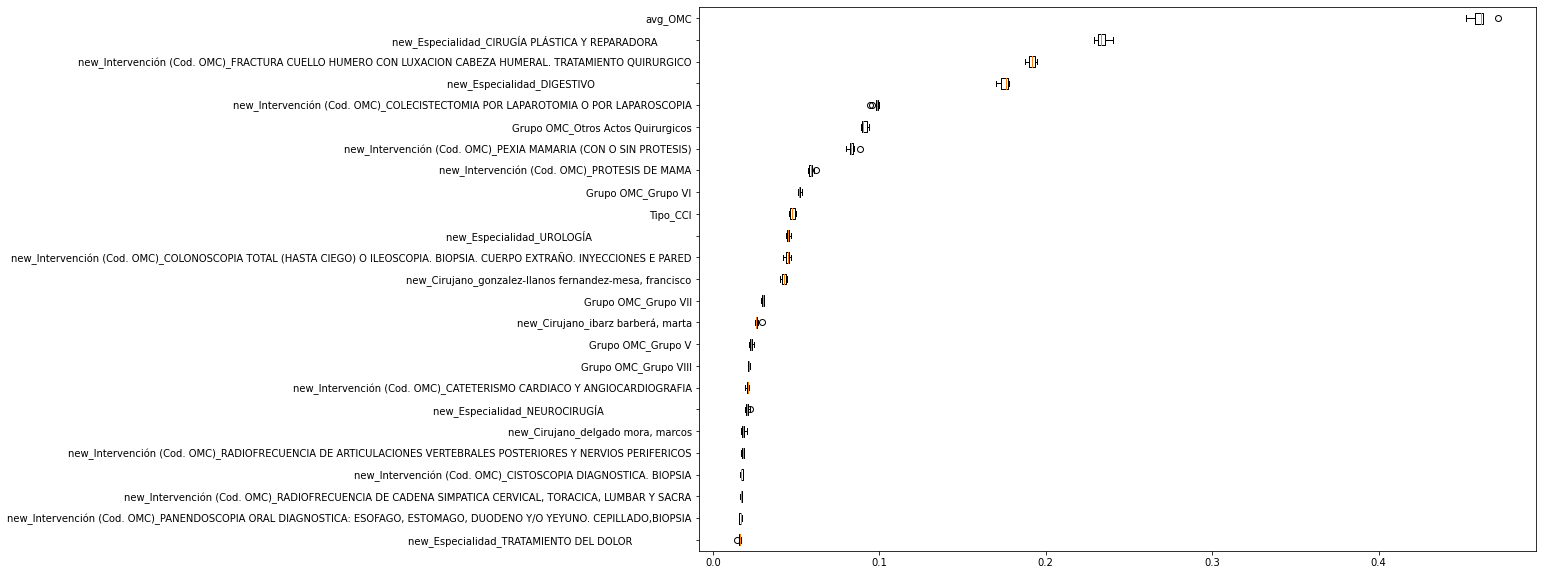

In [ ]:
n_top = 25
perm_sorted_idx = result_importance.importances_mean.argsort()[-n_top:]

plt.figure(figsize=(15,10))
plt.boxplot(result_importance.importances[perm_sorted_idx].T, vert=False, 
            labels=train_dataset.columns[perm_sorted_idx]);


# Calibration of a Model

## Ridge Regression Calibration

In [ ]:
n_folds = 5

def mae_error(y_true, y_pred):
  """
  Define score used for calibration.
  """
  return metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))

def mae_error(y_true, y_pred):
  return metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))

score = make_scorer(mae_error, greater_is_better=False)

In [ ]:
linear_model.Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
alpha_vals = np.arange(0.0001, 0.01, 0.0005)
print("Nr. of alpha parameters tested :: ", alpha_vals.size)
grid_params = {
    'alpha' : alpha_vals,
    'normalize' : [True]
}


Nr. of alpha parameters tested ::  20


## Lasso Regression

In [ ]:
linear_model.Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [ ]:
alpha_vals = np.arange(0.0001, 0.001, 0.00005)
print("Nr. of alpha parameters tested :: ", alpha_vals.size)
grid_params = {
    'alpha' : alpha_vals,
    'normalize' : [False]
}


Nr. of alpha parameters tested ::  18


## Random Forest


In [ ]:
RandomForestRegressor(random_state=1, n_jobs=-1, criterion='mse').get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

## Running Grid Search

In [ ]:
%%time

model = create_regression_model(index_type=2)
print("Using model :: ", model)

print("** PARAMETERS ::  ")
pprint(grid_params)
print("*"*80)

#grid = GridSearchCV(model, grid_params, cv=n_folds, n_jobs=-1, scoring = my_score, verbose=1)
grid = RandomizedSearchCV(model, grid_params, cv=n_folds, n_jobs=-1, scoring = score, verbose=5)
results = grid.fit(train_dataset, log_train_labels)
print("Best score obtained in the search = {:.3f}".format(grid.best_score_))
print("Best parameters = {}".format(grid.best_params_))

Using model ::  Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
** PARAMETERS ::  
{'alpha': array([0.0001 , 0.00015, 0.0002 , 0.00025, 0.0003 , 0.00035, 0.0004 ,
       0.00045, 0.0005 , 0.00055, 0.0006 , 0.00065, 0.0007 , 0.00075,
       0.0008 , 0.00085, 0.0009 , 0.00095]),
 'normalize': [False]}
********************************************************************************
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Best score obtained in the search = -17.100
Best parameters = {'normalize': False, 'alpha': 0.00015000000000000001}
CPU times: user 11.6 s, sys: 2.03 s, total: 13.6 s
Wall time: 2min 24s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.855028400350193, tolerance: 0.8483660148258413
  positive)


In [ ]:
dfResults = pd.DataFrame(results.cv_results_)
dfResults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_normalize,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.850166,0.226764,0.009815,0.004077,False,0.00015,"{'normalize': False, 'alpha': 0.00015000000000...",-16.700741,-17.169912,-17.625229,-17.134828,-16.868576,-17.099857,0.314621,1
1,2.662847,0.046727,0.007517,0.000631,False,0.00075,"{'normalize': False, 'alpha': 0.00075000000000...",-18.521377,-18.815500,-23.668352,-18.895524,-18.499320,-19.680015,2.000306,9
2,2.958393,0.221987,0.006759,0.000802,False,0.00065,"{'normalize': False, 'alpha': 0.00065000000000...",-18.384640,-18.657698,-22.942235,-18.723228,-18.346841,-19.410928,1.771777,7
3,6.636018,1.042118,0.007425,0.000393,False,0.0005,"{'normalize': False, 'alpha': 0.00050000000000...",-17.845309,-18.130388,-20.759917,-18.127960,-17.848071,-18.542329,1.115968,5
4,7.702086,0.064159,0.006882,0.000152,False,0.00025,"{'normalize': False, 'alpha': 0.00025}",-17.008678,-17.367014,-18.018630,-17.280336,-17.049350,-17.344802,0.363033,2
5,2.643336,0.148575,0.007458,0.000382,False,0.0007,"{'normalize': False, 'alpha': 0.00070000000000...",-18.454635,-18.739325,-23.312785,-18.809754,-18.422054,-19.547711,1.888691,8
6,2.399336,0.086312,0.007037,0.000620,False,0.0008,"{'normalize': False, 'alpha': 0.00080000000000...",-18.589322,-18.889589,-23.995413,-18.978863,-18.570762,-19.804790,2.101488,10
7,6.719096,0.741605,0.007362,0.000389,False,0.00045,"{'normalize': False, 'alpha': 0.00045000000000...",-17.648488,-17.967437,-19.819513,-17.928479,-17.658187,-18.204421,0.818323,4
8,6.959447,0.743410,0.007586,0.000892,False,0.00055,"{'normalize': False, 'alpha': 0.00055000000000...",-18.056559,-18.311932,-22.070590,-18.351415,-18.046257,-18.967351,1.556727,6
9,6.991573,0.925537,0.006788,0.001560,False,0.00035,"{'normalize': False, 'alpha': 0.00035000000000...",-17.301985,-17.650705,-18.654208,-17.566332,-17.330272,-17.700700,0.495161,3


Best result = -17.100 obtained with Parameters = {'normalize': False, 'alpha': 0.00015000000000000001}


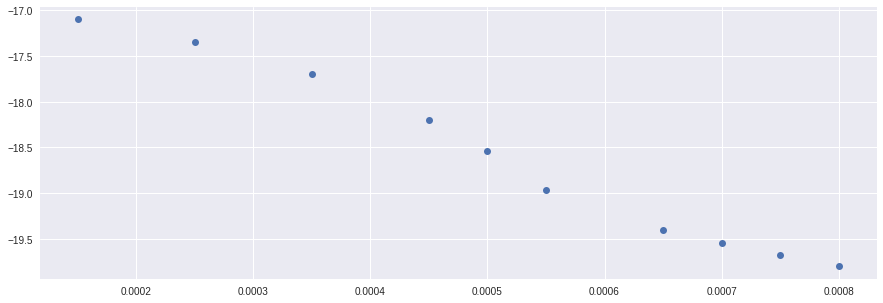

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dfResults['param_alpha'], dfResults['mean_test_score'], 'o');
print("Best result = {:.3f} obtained with Parameters = {}".format(grid.best_score_, grid.best_params_))

In [ ]:
results.best_params_

{'alpha': 0.007}

# Global Models

We compare the following methods over the entire dataset, after cleaning and removing some observations:
* Random Forest
* Support Vector Machine
* Regression
* Gradient Boosting
* ...

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/research/health/or/data_HLA/data/data_2019_scores_v2.xlsx')
print(f"Dataframe with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataframe with 20350 rows and 55 columns.


This dataset, ``df_ml``, contains only surgeries with duration > 10' and < 600'. We eliminate extremely short surgeries and a few unusually long cases.

In [ ]:
%%time
with open('/content/drive/MyDrive/research/health/or/data_HLA/data/data_ml.pkl', 'rb') as f:
  df_ml = pickle.load(f)
print(f"Dataframe with {df_ml.shape[0]} rows and {df_ml.shape[1]} columns.")

Dataframe with 14576 rows and 347 columns.
CPU times: user 2.81 ms, sys: 5.89 ms, total: 8.7 ms
Wall time: 21.1 ms


In [ ]:
#dfAux = df_.dropna(subset=['avg_surgeon'])
baseline_mae_surgeon = np.mean(np.abs(df_ml['or_time'] - df_ml['avg_surgeon']))
baseline_mae_OMC = np.mean(np.abs(df_ml['or_time'] - df_ml['avg_OMC']))
print("Dataset with {} rows and {} columns.".format(df_ml.shape[0], df_ml.shape[1]))
print("Baseline MAEs :")
print("\t Using Surgeon Averages = {:.3f}".format(baseline_mae_surgeon))
print("\t Using OMC Averages = {:.3f}".format(baseline_mae_OMC))

Dataset with 14576 rows and 347 columns.
Baseline MAEs :
	 Using Surgeon Averages = 21.175
	 Using OMC Averages = 37.302


Now I consider the ``dm_lm`` the full dataset to be used in cross-validation. Thus, this will provide training and testing results. If we want to have *training, testing*, and *validation*, then we can use ``train_dataset`` for cross-validation (training and testing) and ``test_dataset`` for validation.

In [ ]:
%%time
with open('/content/drive/MyDrive/research/health/or/data_HLA/data/data_training.pkl', 'rb') as f:
  train_dataset = pickle.load(f)
with open('/content/drive/MyDrive/research/health/or/data_HLA/data/data_testing.pkl', 'rb') as f:
  test_dataset = pickle.load(f)
print("Training of size {} x {} and testing of size {} x {}.".format(train_dataset.shape[0], train_dataset.shape[1], test_dataset.shape[0], test_dataset.shape[1]))

Training of size 11661 x 347 and testing of size 2915 x 347.
CPU times: user 7.45 ms, sys: 5.03 ms, total: 12.5 ms
Wall time: 27.2 ms


In [ ]:

dfAux = train_dataset
baseline_mae_surgeon = np.mean(np.abs(train_dataset['or_time'] - train_dataset['avg_surgeon']))
baseline_mae_OMC = np.mean(np.abs(train_dataset['or_time'] - train_dataset['avg_OMC']))
print("Training Dataset with {} rows and {} columns.".format(train_dataset.shape[0], train_dataset.shape[1]))
print("Baseline MAEs :")
print("\t Using Surgeon Averages = {:.3f}".format(baseline_mae_surgeon))
print("\t Using OMC Averages = {:.3f}".format(baseline_mae_OMC))

dfAux = test_dataset
baseline_mae_surgeon = np.mean(np.abs(test_dataset['or_time'] - test_dataset['avg_surgeon']))
baseline_mae_OMC = np.mean(np.abs(test_dataset['or_time'] - test_dataset['avg_OMC']))
print("Testing Dataset with {} rows and {} columns.".format(test_dataset.shape[0], test_dataset.shape[1]))
print("Baseline MAEs :")
print("\t Using Surgeon Averages = {:.3f}".format(baseline_mae_surgeon))
print("\t Using OMC Averages = {:.3f}".format(baseline_mae_OMC))

Training Dataset with 11661 rows and 347 columns.
Baseline MAEs :
	 Using Surgeon Averages = 21.269
	 Using OMC Averages = 37.321
Testing Dataset with 2915 rows and 347 columns.
Baseline MAEs :
	 Using Surgeon Averages = 20.798
	 Using OMC Averages = 37.224


In [ ]:
# separate DV
#train_dataset = df_ml.copy(deep=True) # NOTE: how to deal with train/test/validate
train_labels = train_dataset.pop('or_time')
test_labels = test_dataset.pop('or_time')

## Regression Models

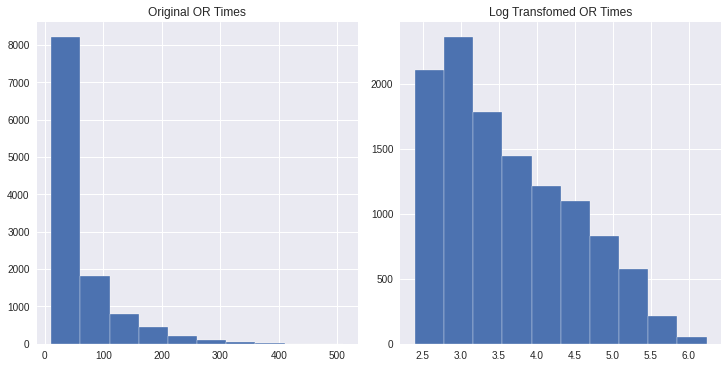

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10,5))
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
fig.add_subplot(gs[0, 0])
plt.hist(train_labels, edgecolor='white')
plt.title("Original OR Times");

log_train_labels = np.log(train_labels)
fig.add_subplot(gs[0, 1])
plt.hist(log_train_labels, edgecolor='white')
plt.title("Log Transfomed OR Times");

In [ ]:
# define custom score functions
def mae_error(y_true, y_pred):
  """
  We need to use e^y, since we are working with log DV.
  """
  return -metrics.mean_absolute_error(np.exp(y_true), np.exp(y_pred))
def R2_score(y_true, y_pred):
  ybar = np.mean(y_true)
  SSTot = np.var(y_true, ddof=1)*(len(y_true)-1)
  SSE = sum((y_pred.ravel() - y_true.ravel())**2)
  return (1-SSE/SSTot)

score = make_scorer(mae_error, greater_is_better=False)
scoring = {'R2' : make_scorer(R2_score, greater_is_better=True),
           'mae' : make_scorer(mae_error, greater_is_better=False)}

In [ ]:
# Create linear regression object
regrTypes = ['linear', 'ridge', 'lasso', 'lassoCV', 'bayesianRidge', 'huber']
regression_type = regrTypes[4]

if regression_type == 'linear':
  regr = linear_model.LinearRegression(n_jobs=-1, normalize=False)
elif regression_type == 'ridge':
  regr = linear_model.Ridge(alpha=0.5, normalize=False)
elif regression_type == 'lasso':
  regr = linear_model.Lasso(alpha=0.0001, normalize=False)
elif regression_type == 'lassoCV':
  alpha_list = np.arange(0.0001,1,0.1)
  regr = linear_model.LassoCV(alphas=alpha_list, cv= 10, normalize=False, n_jobs=-1)
elif regression_type == 'bayesianRidge':
  regr = linear_model.BayesianRidge()
elif regression_type == 'huber':
  regr = linear_model.HuberRegressor(epsilon=1.1, max_iter=2000)

# fitting the model
#model = regr.fit(train_dataset, log_train_labels)

# Train the model using the training sets
print("Regression Model :: ", regr)

# using the entire dataset
n_folds = 5
#from sklearn.model_selection import cross_val_score
table = cross_validate(regr, train_dataset, log_train_labels, cv=n_folds, scoring = scoring, return_train_score=True, verbose=10, n_jobs=1)
#table = cross_val_score(regr, train_dataset, log_train_labels, cv=n_folds,  scoring= score, verbose=10, n_jobs=1)



print("\n\nSummary Results {}-fold Cross Validation :: ".format(n_folds))
print("Training Avg R^2 :: \t{:10.3f}".format(np.mean(table['train_R2'])))
print("Training Avg neg MAS :: {:10.3f}".format(np.mean(table['train_mae'])))
print("Testing Avg R^2 :: \t{:10.3f}".format(np.mean(table['test_R2'])))
print("Testing Avg neg MAS ::  {:10.3f}\n\n".format(np.mean(table['test_mae'])))

# validation
final_model = regr.fit(train_dataset, log_train_labels) # specify parameters here
y_pred = np.exp(regr.predict(test_dataset))
y_test = test_labels

print("\n** TESTING DATA **")
print("R^2 on Testing Data: \t {:.3f}".format(regr.score(test_dataset, np.log(test_labels))))
print('Mean Absolute Error: \t {:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: \t {:.3f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

if regression_type == 'lassoCV':
  print("++ Chosen alpha value = ", final_model.alpha_)


Regression Model ::  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , R2=(train=0.799, test=0.790), mae=(train=16.727, test=16.035), total=   0.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  , R2=(train=0.803, test=0.775), mae=(train=16.402, test=17.960), total=   0.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  , R2=(train=0.804, test=0.772), mae=(train=16.379, test=17.212), total=   0.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV]  , R2=(train=0.795, test=0.807), mae=(train=16.375, test=17.416), total=   0.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV]  , R2=(train=0.801, test=0.778), mae=(train=16.545, test=16.995), total=   0.8s


Summary Results 5-fold Cross Validation :: 
Training Avg R^2 :: 	     0.800
Training Avg neg MAS ::     16.486
Testing Avg R^2 :: 	     0.785
Testing Avg neg MAS ::      17.124




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished



** TESTING DATA **
R^2 on Testing Data: 	 0.796
Mean Absolute Error: 	 17.100
Mean Squared Error: 	 1091.535
Root Mean Squared Error: 33.038


## Voting Regressors

In [ ]:
from sklearn.ensemble import VotingRegressor
# Create linear regression object
regr_names = ['linear', 'ridge', 'lasso', 'bayesianRidge', 'huber']

regr0 = linear_model.LinearRegression(n_jobs=-1, normalize=False).fit(train_dataset, log_train_labels)
regr1 = linear_model.Ridge(alpha=0.5, normalize=False).fit(train_dataset, log_train_labels)
regr2 = linear_model.Lasso(alpha=0.0001, normalize=False).fit(train_dataset, log_train_labels)
regr3 = linear_model.BayesianRidge().fit(train_dataset, log_train_labels)
#regr4 = linear_model.HuberRegressor(epsilon=1.1, max_iter=2000).fit(train_dataset, log_train_labels)

#vote_regr = VotingRegressor([(regr_names[0], regr0), (regr_names[1], regr1), (regr_names[2], regr2), (regr_names[3], regr3), (regr_names[4], regr4), (regr_names[5], regr5)])
vote_regr = VotingRegressor([(regr_names[0], regr0), (regr_names[1], regr1), (regr_names[2], regr2), (regr_names[3], regr3)])
#vote_regr = VotingRegressor([(regr_names[0], regr0), (regr_names[1], regr1)])
vote_regr.fit(train_dataset, log_train_labels)
print("Regression Model :: ")
print("*"*19)
print("R^2 on Training Data: \t {:.3f}".format(vote_regr.score(train_dataset, log_train_labels)))

y_pred = np.exp(vote_regr.predict(test_dataset))
y_test = test_labels

print("\n** TESTING DATA **")
print("R^2 on Testing Data: \t {:.3f}".format(vote_regr.score(test_dataset, np.log(test_labels))))
print('Mean Absolute Error: \t {:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: \t {:.3f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))


Regression Model :: 
*******************
R^2 on Training Data: 	 0.801

** TESTING DATA **
R^2 on Testing Data: 	 0.796
Mean Absolute Error: 	 16.958
Mean Squared Error: 	 1043.751
Root Mean Squared Error: 32.307


# Multiple ML Models

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]

## Tuning ML Method via Grid Search

In [ ]:
# Number of trees in random forest
def grid_RF():
    n_estimators = np.arange(250,301,50)
    # Number of features to consider at every split
    #max_features = ['auto', 'sqrt']
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = np.arange(100,350,50)
    # Minimum number of samples required to split a node
    #min_samples_split = [2, 5, 10]
    min_samples_split = [5, 8, 10]
    # Minimum number of samples required at each leaf node
    #min_samples_leaf = [2, 4]
    min_samples_leaf = [4,8, 12]
    # Method of selecting samples for training each tree
    bootstrap = [True]
    # Create the random grid
    grid_params = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}
    pprint(grid_params)
    return grid_params

grid_params = grid_RF()
model = RandomForestRegressor(random_state=1, n_jobs=-1, criterion='mae')
grid = RandomizedSearchCV(model, grid_params, cv=n_folds, n_jobs=-1, scoring = score, verbose=10)
results = grid.fit(train_dataset, log_train_labels)
print("Best score obtained in the search = {:.3f}".format(grid.best_score_))
print("Best parameters = {}".format(grid.best_params_))

In [ ]:
regressors = [RandomForestRegressor(random_state=1), GradientBoostingRegressor(random_state=1), BaggingRegressor(random_state=1), ExtraTreesRegressor(random_state=1), 
              StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)), HistGradientBoostingRegressor()]
names = ['RandomForestRegressor', 'GradientBoostingRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 'StackingRegressor', 'HistGradientBoostingRegressor']
for name, regressor in zip(names, regressors):
  print("Training {}".format(regressor))
  regr = regressor
  model = regressor

  table = cross_validate(model, train_dataset, log_train_labels, cv=n_folds, scoring = scoring, return_train_score=True, verbose=0, n_jobs=-1)


  print("\n\nSummary Results:: ")
  print("Training Avg R^2 :: \t{:10.3f}".format(np.mean(table['train_R2'])))
  print("Training Avg neg MAS :: {:10.3f}".format(np.mean(table['train_mae'])))
  print("Testing Avg R^2 :: \t{:10.3f}".format(np.mean(table['test_R2'])))
  print("Testing Avg neg MAS ::  {:10.3f}\n\n".format(np.mean(table['test_mae'])))
  
  regr.fit(train_dataset, log_train_labels)

  y_pred = np.exp(regr.predict(test_dataset))
  y_test = test_labels

  mae = metrics.mean_absolute_error(y_test, y_pred)
  print("\n** TESTING DATA **")
  print(f'\n++ Mean Absolute Error on testing set: \t{mae:.2f} minutes.')


Training RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)


Summary Results:: 
Training Avg R^2 :: 	     0.944
Training Avg neg MAS ::      7.602
Testing Avg R^2 :: 	     0.786
Testing Avg neg MAS ::      16.696



** TESTING DATA **

++ Mean Absolute Error on testing set: 	16.93 minutes.
Training GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_im

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn


** TESTING DATA **

++ Mean Absolute Error on testing set: 	19.24 minutes.
Training HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning




Summary Results:: 
Training Avg R^2 :: 	     0.851
Training Avg neg MAS ::     13.905
Testing Avg R^2 :: 	     0.799
Testing Avg neg MAS ::      16.252



** TESTING DATA **

++ Mean Absolute Error on testing set: 	16.17 minutes.


# XGBoost

In [ ]:
!pip3 install xgboost
import xgboost
print(xgboost.__version__)
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

0.90


In [ ]:
# define the model
model = XGBRegressor()

n_folds = 5
#from sklearn.model_selection import cross_val_score
table = cross_validate(model, train_dataset, log_train_labels, cv=n_folds, scoring = scoring, return_train_score=True, verbose=10, n_jobs=1)
#table = cross_val_score(regr, train_dataset, log_train_labels, cv=n_folds,  scoring= score, verbose=10, n_jobs=1)



print("\n\nSummary Results {}-fold Cross Validation :: ".format(n_folds))
print("Training Avg R^2 :: \t{:10.3f}".format(np.mean(table['train_R2'])))
print("Training Avg neg MAS :: {:10.3f}".format(np.mean(table['train_mae'])))
print("Testing Avg R^2 :: \t{:10.3f}".format(np.mean(table['test_R2'])))
print("Testing Avg neg MAS ::  {:10.3f}\n\n".format(np.mean(table['test_mae'])))

# validation
final_model = regr.fit(train_dataset, log_train_labels) # specify parameters here
y_pred = np.exp(regr.predict(test_dataset))
y_test = test_labels

print("\n** TESTING DATA **")
print("R^2 on Testing Data: \t {:.3f}".format(regr.score(test_dataset, np.log(test_labels))))
print('Mean Absolute Error: \t {:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: \t {:.3f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

if regression_type == 'lassoCV':
  print("++ Chosen alpha value = ", final_model.alpha_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[08:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  , R2=(train=0.802, test=0.797), mae=(train=16.304, test=15.701), total=   6.9s
[CV]  ................................................................
[08:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  , R2=(train=0.808, test=0.781), mae=(train=15.819, test=17.180), total=   6.8s
[CV]  ................................................................
[08:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s


[CV]  , R2=(train=0.808, test=0.777), mae=(train=15.975, test=16.885), total=   6.7s
[CV]  ................................................................
[08:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.7s remaining:    0.0s


[CV]  , R2=(train=0.800, test=0.812), mae=(train=15.944, test=16.799), total=   6.7s
[CV]  ................................................................
[08:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.5s remaining:    0.0s


[CV]  , R2=(train=0.805, test=0.791), mae=(train=16.042, test=16.147), total=   6.7s


Summary Results 5-fold Cross Validation :: 
Training Avg R^2 :: 	     0.805
Training Avg neg MAS ::     16.017
Testing Avg R^2 :: 	     0.792
Testing Avg neg MAS ::      16.542




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.4s finished



** TESTING DATA **
R^2 on Testing Data: 	 0.813
Mean Absolute Error: 	 16.175
Mean Squared Error: 	 970.823
Root Mean Squared Error: 31.158
